In [1]:
import rospy
import sensor_msgs.point_cloud2 as pc2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from subprocess import Popen
import sys
sys.path.insert(0, "/home/ankit/rosbag/pyniel") # Pyniel as available on github
from numpy_tools.gridify import gridify
%matplotlib notebook
plt.ion()

global frames
frames = []
MAX_FRAMES = 200

In [2]:
#!/usr/bin/env python
def callback(data):
    global frames
    rospy.loginfo("Frame: %s " +  rospy.get_caller_id() + "I heard %s", len(frames), data.width)
    clear_output(wait=True)
    frames.append(data)
    if len(frames) > MAX_FRAMES:
      rospy.signal_shutdown("Message received")
    
def listener():
    # In ROS, nodes are uniquely named. If two nodes with the same
    # node are launched, the previous one is kicked off. The
    # anonymous=True flag means that rospy will choose a unique
    # name for our 'listener' node so that multiple listeners can
    # run simultaneously.
    rospy.init_node('listener', anonymous=True)

    rospy.Subscriber("/velodyne_points", pc2.PointCloud2, callback)

    # spin() simply keeps python from exiting until this node is stopped
    rospy.spin()

if __name__ == '__main__':
#     pcore = Popen(['roscore'])
#     p = Popen(['rosbag','play','/home/ankit/rosbag/2018-03-06-14-03-06.bag']) # something long running
    listener()
#     p.terminate()
#     pcore.terminate()

[INFO] [1521712935.729314]: Frame: 196 /listener_7273_1521712915647I heard 12115


In [3]:
old_frames = frames

In [4]:
frames = old_frames
frames = [np.array([list(point) for point in pc2.read_points(frame, field_names = None)]) 
          for frame in frames]

In [98]:
# for i in range(len(frames)):
#     print len(frames[i])
print frames[0]
ind = 4
print max(frames[0][:,ind]), min(frames[0][:,ind])
print max(frames[0][:,3]), min(frames[0][:,3])

[[  1.55924129  -3.01838875   0.17804694   1.           9.        ]
 [  0.25834545  -0.5011788   -0.04933015  20.           5.        ]
 [  1.49611032  -2.90487766  -0.17124327   1.           6.        ]
 ..., 
 [  0.22842754  -0.5023998   -0.04828428  21.           5.        ]
 [  1.33486259  -2.93859744  -0.16914983  24.           6.        ]
 [  1.32026982  -2.90782022  -0.05574299  18.           7.        ]]
15.0 3.0
123.0 1.0


In [99]:
ind = 4
ring_id = 13
get_rings_0 = frames[0][:,ind]

def get_ring_i(ring_id, scan_id):
    get_rings = frames[scan_id][:,4]
    ring_0 = np.where(get_rings == ring_id)
#     print ring_0
    points_in_ring_0 = frames[scan_id][ring_0, :][0]
#     print points_in_ring_0[:,0:3]
#     print max(points_in_ring_0[:,0]), min(points_in_ring_0[:,0])

    x0 = points_in_ring_0[:,0]
    y0 = points_in_ring_0[:,1]
    z0 = points_in_ring_0[:,2]
    
    i0 = points_in_ring_0[:,3]
    
#     return x, y, z

#     x0, y0, z0 = get_ring_i(0, get_rings)
#     plt.figure()
#     plt.scatter(x0, y0, marker='s', edgecolor="none")


    w0 = np.arctan2(y0, x0)
    r0 = np.sqrt(x0*x0+y0*y0)
    r0_log = np.log10(r0+1)
    
    return x0, y0, z0, w0, r0_log, i0

In [100]:
print len(frames)

197


<IPython.core.display.Javascript object>


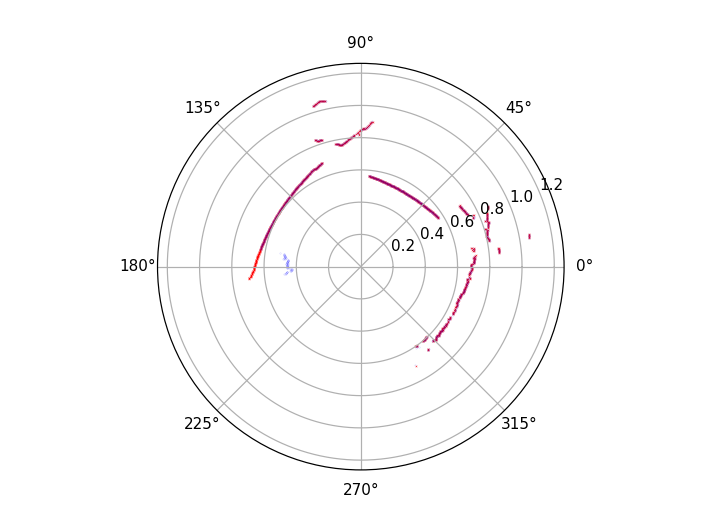

In [101]:
x0, y0, z0, w0, r0_log, i0 = get_ring_i(13, 0)
x1, y1, z1, w1, r1_log, i1 = get_ring_i(13, 40) #50


fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(w0, r0_log, cmap='hsv', alpha=0.75, s=0.05, marker='x', c='r')
c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.2, s=0.05, marker='o', c='b')


In [102]:
# # https://gist.github.com/temporaer/6755266
# def plot_logpolar(ax, theta, r_, bullseye=None, **kwargs):
#     min10 = np.log10(np.min(r_))
#     max10 = np.log10(np.max(r_))
#     if bullseye is None:
#         bullseye = min10 - np.log10(0.5 * np.min(r_))
#     r = np.log10(r_) - min10 + bullseye
#     ax.plot(theta, r, **kwargs)
#     l = np.arange(np.floor(min10), max10)
#     ax.set_rticks(l - min10 + bullseye) 
#     ax.set_yticklabels(["1e%d" % x for x in l])
#     ax.set_rlim(0, max10 - min10 + bullseye)
#     ax.set_title('log-polar manual')
#     return ax

# ax = plt.subplots(1, 2, subplot_kw=dict(polar=True))[1].flatten()
# plot_logpolar(ax[0], w0, r0_log)

In [103]:
# assuming 1600 points per ring, 360/1600 = 0.225 degrees
# divide log radius into 1200 parts
# divide ring into worst case horizontal angular resolution = 0.4 degrees
# divide log distance by 0.05
def occupancy(w, r_log):
    oc_grid = np.zeros((901, 200))
    angle_bin = np.rint(w*57.2958/0.4)+450
    distance_bin = np.rint(r_log/0.1)
    
    angle_bin = angle_bin.astype(int)
    distance_bin = distance_bin.astype(int)
#     print angle_bin
#     print distance_bin
    
#     print max(angle_bin), min(angle_bin)
#     print max(distance_bin), min(distance_bin)
    
    oc_grid[angle_bin, distance_bin] += 1
    return oc_grid

oc_grid = occupancy(w0, r0_log)
# print np.where(oc_grid == 1)

# plt.figure()
# plt.hist(np.where(oc_grid != 0)[1])

In [104]:
print "ere"
oc_grid_static = occupancy(w0, r0_log)
oc_grid_smoky = occupancy(w1, r1_log)

ere


In [106]:
def groundtruth_ring(static, smoky):
    gt = smoky - static
    r, c = np.where(gt < 1)
    gt[r, c] = 0
    return gt

def unpack_gt(gt, x_smoky, y_smoky, z_smoky, w_smoky, r_smoky, i_smoky):
    x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt = [], [], [], [], [], [], []
    
    angle_bin = np.rint(w_smoky*57.2958/0.4) + 450
    distance_bin = np.rint(r_smoky/0.1)
    
    angle_bin = angle_bin.astype(int)
    distance_bin = distance_bin.astype(int)
    print angle_bin
    print distance_bin
    
    print len(angle_bin), len(distance_bin)
    
    r, c = np.where(gt == 1)
    print r, c
    
    for i in range(len(angle_bin)):
        if angle_bin[i] in r and distance_bin[i] in c:
            x_gt.append(x_smoky[i])
            y_gt.append(y_smoky[i])
            z_gt.append(z_smoky[i])
            w_gt.append(w_smoky[i])
            r_gt.append(r_smoky[i])
            label_gt.append(1)
            i_gt.append(i_smoky[i])
        else:
            x_gt.append(x_smoky[i])
            y_gt.append(y_smoky[i])
            z_gt.append(z_smoky[i])
            w_gt.append(w_smoky[i])
            r_gt.append(r_smoky[i])
            label_gt.append(0)
            i_gt.append(i_smoky[i])
    
    return x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt
    

gt_grid = groundtruth_ring(oc_grid_static, oc_grid_smoky)
x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt = unpack_gt(gt_grid, x1, y1, z1, w1, r1_log, i1)
print len(x_gt)
print len(y_gt)
print len(z_gt)
print len(w_gt)
print len(r_gt)
print len(label_gt)
print len(i_gt)

[ 14  14  13 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1140 1140
[  0   1   2   3   3   4   5   6   7   8   9  10  11  12  13  14 324 339
 341 371 378 388 395 424 437 469 514 663 705 754 876 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899
 900] [ 5  5  5  4  5  4  4  4  4  4  4  5  5  5  5  5  7  7  7  6  6  6  6  7  7
  7  7  6 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5]
1140
1140
1140
1140
1140
1140
1140


<IPython.core.display.Javascript object>


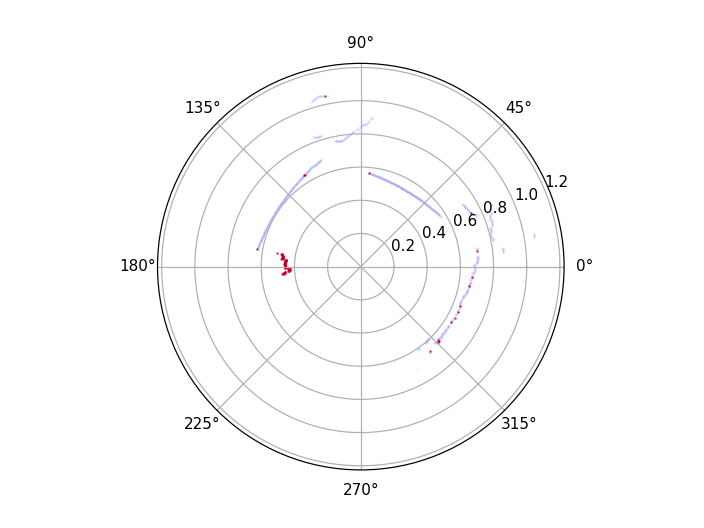

In [107]:
smoky_points = np.where(np.array(label_gt) == 1)[0]
# print smoky_points
w_gt = np.array(w_gt)
r_gt = np.array(r_gt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(w_gt[smoky_points], r_gt[smoky_points], cmap='hsv', alpha=1.0, s=0.2, marker='x', c='r')
c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.1, s=0.1, marker='o', c='b')

In [108]:
print max(r1_log)-min(r1_log), min(w0)
x = np.array(np.arange(10))
x = np.reshape(x, (2,5))
print x
print np.where(x >=16)

0.638802666218 -3.14037084577
[[0 1 2 3 4]
 [5 6 7 8 9]]
(array([], dtype=int64), array([], dtype=int64))


In [110]:
def generate_files(frames, static_id, dataset_id, display_flag=False):
#     static_id = 0
#     dataset_id = 0
    # generate ground truth
    # x0, y0, z0, w0, r0_log = get_ring_i(13, 0)
    # x1, y1, z1, w1, r1_log = get_ring_i(13, 40) #50

#     print frames[0]
    ind = 4
    print max(frames[0][:,ind]), min(frames[0][:,ind])

    rings_present = [int(i) for i in np.unique(frames[0][:,ind])]
    print rings_present

    static_scene = {}
    for ring_id in rings_present:
        x0, y0, z0, w0, r0_log, i0 = get_ring_i(ring_id, static_id)
        static_scene[ring_id] = {"x0":x0, "y0":y0, "z0":z0, "w0":w0, "r0_log":r0_log, "i0":i0}

    # print static_scene[10].keys()

    for frame_id in range(len(frames)):
        # do I need to do this?
    #     if frame_id == static_id:
    #         continue

        dynamic_scene = {}
        for ring_id in rings_present:
            x1, y1, z1, w1, r1_log, i1 = get_ring_i(ring_id, frame_id)
            oc_grid_static = occupancy(static_scene[ring_id]["w0"], static_scene[ring_id]["r0_log"])
            oc_grid_smoky = occupancy(w1, r1_log)

            gt_grid = groundtruth_ring(oc_grid_static, oc_grid_smoky)
            x_gt, y_gt, z_gt, w_gt, r_gt, label_gt, i_gt = unpack_gt(gt_grid, x1, y1, z1, w1, r1_log, i1)
            dynamic_scene[ring_id] = {"x_gt":x_gt, "y_gt":y_gt, "z_gt":z_gt, \
                                      "w_gt":w_gt, "r_gt":r_gt, "label_gt":label_gt, "i_gt":i_gt}

            if display_flag == True:
                smoky_points = np.where(np.array(label_gt) == 1)[0]
                # print smoky_points
                w_gt = np.array(w_gt)
                r_gt = np.array(r_gt)
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='polar')
                c = ax.scatter(w_gt[smoky_points], r_gt[smoky_points], cmap='hsv', alpha=1.0, s=0.2, marker='x', c='r')
                c = ax.scatter(w1, r1_log, cmap='hsv', alpha=0.1, s=0.1, marker='o', c='b')

        np.savez_compressed(str(dataset_id) + "_" + str(frame_id), gt=dynamic_scene)


generate_files(frames, 0, 0)

15.0 3.0
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[279 273 272 271 266 265 263  28]
[2 2 2 2 2 2 2 2]
8 8
[] []
[289 287]
[2 2]
2 2
[] []
[293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285
 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276
 275 275 274 273 271 841 841 840 840 839 839 838 838 837 837 836 836 835
 835 834 834 833 833 832 832 831 831 830 830 829 829 828 828 809 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790
 790 789 785 784 784 783 783 782 782 781 781 780 780 779 779 778 778 777
 777 776 775 775 773 772 771 770 770 768 768 767 766 766 765 765 764 764
 762 761 759 755 736 735 735 734 734 732 732 729 728 675 675 674 674 673
 673 672 672 671 671 670 670 669 669 668 667 657 652 643 642 642 641 638
 637 637 636 634 632 628 625 623 623 622 622 621 621 620 620 619 619 618
 618 617 617 616 616 615 615 614 614 613 613 612 612 6

[] []
[293  21  20 ..., 301 301 292]
[7 7 7 ..., 6 6 7]
1193 1193
[] []
[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1204 1204
[] []
[ 16  15  15 ..., 312 311 298]
[7 7 7 ..., 6 6 7]
1138 1138
[] []
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1160 1160
[] []
[ 10   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[] []
[279 272 264 262  29  25]
[2 2 2 2 2 2]
6 6
[ 25  29 262 264] [2 2 2 2]
[]
[]
0 0
[] []
[286 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 277 277
 276 275 274 271 841 841 840 840 839 839 838 838 837 837 836 836 835 835
 834 834 833 833 832 832 831 831 830 830 829 829 828 826 821 810 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790
 790 789 785 784 784 783 783 782 782 781 781 780 780 779 779 778 778 777
 777 776 776 775 775 773 773 772 771 770 769 769 767 766 766 766 765 762
 762 759 756 755 754 737 736 736 735 735 734 734 731 701 700 678 

[371 550 552 645 663 754] [6 5 6 5 6 6]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1161 1161
[342 359 530 551 646 754 892] [6 6 9 5 5 7 6]
[ 10   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[340 341 408 550] [7 7 7 5]
[277 274 261 280 279]
[2 2 2 2 2]
5 5
[261 274 277 280] [2 2 2 2]
[288]
[2]
1 1
[288] [2]
[278 278 277 277 276 275 275 274 273 273 272 841 841 840 840 839 839 838
 838 837 837 836 836 835 835 834 834 833 833 832 832 831 831 830 830 829
 829 828 826 823 822 822 821 818 816 809 808 808 807 807 806 806 805 805
 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797 797 796 796
 795 795 794 794 793 793 792 792 791 791 790 790 785 784 784 783 783 782
 782 781 781 780 779 779 778 778 777 777 776 776 775 774 774 773 773 772
 768 768 767 766 765 765 764 763 761 759 759 738 737 737 736 736 735 735
 734 731 731 677 676 676 675 675 674 674 673 673 672 672 671 671 670 670
 669 669 668 656 646 644 643 643 642 638 637 636 635 634 634 633 632 632
 631 627 627 625 62

[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1158 1158
[336 342 359 379 468 530 551 754 892] [7 6 6 6 9 9 5 7 6]
[  9   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1178 1178
[339 340 406 552 643] [6 7 6 6 6]
[267 705 283 275 273]
[2 2 2 2 2]
5 5
[267 275 283 705] [2 2 2 2]
[]
[]
0 0
[] []
[269 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 828 827 822 821 821 809 808 808
 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799
 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790
 789 785 784 784 783 783 782 782 781 781 780 780 779 778 778 777 777 776
 776 775 775 774 774 773 773 771 770 770 769 768 768 767 764 763 762 761
 755 754 738 736 735 735 734 731 730 729 728 676 676 675 675 674 674 673
 673 672 672 671 671 670 670 669 669 668 668 667 667 658 648 644 643 642
 642 641 640 639 638 637 636 635 635 634 633 631 630 626 625 623 622 622
 621 621 620 620 619 619 618 618 617 617 616 616 

[ 16  15  15 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1135 1135
[386 388 424 550 551 645 705 754] [ 6  6  7  5  6  5 11  6]
[ 14  13  13 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1161 1161
[ 14 336 342 359 371 379 468 551 552 646 754 892] [7 7 6 6 6 6 9 5 6 5 7 6]
[ 10  10   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[339 340 550 645] [6 7 5 5]
[263  35 298 280 272 267]
[2 2 2 2 2 2]
6 6
[ 35 267 280 298] [2 2 2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 825 823 820 819 811 809 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790
 790 789 785 784 784 783 783 782 782 781 781 780 780 779 779 779 778 777
 777 776 775 774 773 773 772 772 770 769 768 768 766 763 762 761 761 760
 737 736 736 735 735 734 734 732 732 730 730 728 688 679 678 676 675 675
 674 674 673 673 672 672 671 671 670 670 669 669 668 667 

[ 13  12  12 ..., 314 314 313]
[7 7 7 ..., 6 6 6]
1156 1156
[336 342 359 369 371 392 468 470 551 552 663 754] [7 6 6 6 6 6 9 7 5 6 6 7]
[  9   9   8 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1180 1180
[339 368 406 407 550 645 663 669 891] [6 6 6 7 5 5 6 9 7]
[277 267 265]
[2 2 2]
3 3
[267 277] [2 2]
[]
[]
0 0
[] []
[439 438 418 406 406 394 393 393 387 385 385 384 384 383 383 382 382 381
 381 380 380 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372
 372 371 371 370 370 369 369 368 360 360 359 359 358 358 357 357 353 350
 350 349 313 312 312 311 311 310 310 309 309 308 308 307 307 306 306 305
 305 304 304 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296
 296 295 295 294 294 293 293 292 292 291 291 290 290 289 289 288 288 287
 287 286 286 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278
 278 277 277 276 276 275 275 274 274 273 273 271 271 841 841 840 840 839
 839 838 838 837 837 836 836 835 835 834 834 833 833 832 832 831 831 830
 830 829 829 828 828 822 810 80

[442 441 441 ..., 435 435 434]
[7 7 7 ..., 7 7 7]
1177 1177
[336 342 359 379 468 551 552 663 754 892] [7 6 6 7 9 5 6 6 7 6]
[442 441 441 ..., 435 435 434]
[7 7 7 ..., 7 7 7]
1196 1196
[339 340 408 409 550 645 663 669] [6 7 7 6 5 5 6 9]
[290 282 269]
[2 2 2]
3 3
[269 282 290] [2 2 2]
[292 288 288]
[2 2 2]
3 3
[288 292] [2 2]
[418 407 406 406 393 392 386 385 384 384 383 383 382 382 381 381 380 380
 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371
 370 370 369 369 360 360 359 359 358 358 357 357 356 350 350 312 311 311
 310 310 309 309 308 308 307 307 306 306 306 305 305 304 304 303 303 302
 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293
 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284
 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275
 275 274 272 271 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829 829 828 828 827 824 823 822 821
 821 809 808 808 

[367 386 514 552 645 646 754] [6 7 7 6 5 5 6]
[434 433 433 ..., 427 427 426]
[7 7 7 ..., 7 7 7]
1175 1175
[342 371 379 663 754 755 891] [6 6 6 6 7 7 7]
[434 433 433 ..., 427 427 426]
[7 7 7 ..., 7 7 7]
1196 1196
[338 340 646 663 669 754] [6 7 5 6 9 7]
[296 290 274 817]
[2 2 2 2]
4 4
[274 290 296 817] [2 2 2 2]
[287]
[2]
1 1
[] []
[418 412 407 406 406 393 392 386 385 384 384 383 383 382 382 381 381 380
 380 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371
 371 370 370 369 369 360 360 359 359 358 358 357 352 351 312 312 311 311
 311 310 309 309 308 308 308 307 306 306 305 305 304 304 303 303 302 302
 301 301 301 300 300 299 299 298 298 297 297 296 295 295 295 294 294 293
 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284
 284 283 283 282 282 281 281 280 280 279 279 278 277 277 276 276 275 275
 274 273 271 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829 829 828 816 809 808 808 807 807
 806 806 80

[426 425 425 ..., 419 419 418]
[7 7 7 ..., 7 7 7]
1177 1177
[342 359 468 530 551 552 646 663 754] [6 6 9 9 5 6 5 6 7]
[426 425 425 ..., 419 419 418]
[7 7 7 ..., 7 7 7]
1197 1197
[408 409 550 643 645 669 754] [7 6 5 6 5 9 7]
[278 272 270 269 265  33]
[2 2 2 2 2 2]
6 6
[ 33 269 270 278] [2 2 2 2]
[]
[]
0 0
[] []
[406 406 394 393 393 386 386 385 384 384 383 383 382 382 381 381 380 380
 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371
 370 370 369 369 361 360 360 359 359 358 357 357 356 350 312 311 311 310
 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301
 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292
 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283
 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275 274 274
 273 272 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834
 833 833 832 832 831 831 830 830 829 829 828 827 824 821 809 808 808 807
 807 806 806 805 805 804 804 80

[418 417 417 ..., 411 411 410]
[7 7 7 ..., 7 7 7]
1176 1176
[336 342 343 359 369 371 379 392 471 726 754 755] [7 6 7 6 6 6 6 6 8 8 7 7]
[418 417 417 ..., 411 411 410]
[7 7 7 ..., 7 7 7]
1195 1195
[340 368 406 407 529 669] [ 7  6  7  7 10  9]
[288 270 269]
[2 2 2]
3 3
[269 270 288] [2 2 2]
[291]
[2]
1 1
[291] [2]
[406 406 392 387 386 385 385 384 384 383 383 382 382 381 381 380 380 379
 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370
 370 369 369 368 361 360 360 359 359 358 357 353 351 350 350 349 313 312
 311 311 310 310 309 308 308 307 307 306 306 305 305 304 304 303 303 302
 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293
 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284
 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275
 275 274 273 272 270 841 840 840 839 839 839 838 838 837 837 836 836 835
 835 834 834 833 833 832 832 831 831 830 830 829 829 828 826 823 823 809
 809 808 808 807 807 806 806 

[410 409 409 ..., 404 403 403]
[7 6 6 ..., 6 6 6]
1176 1176
[ 14 336 359 369 371 392 468 471 551 726 754] [7 7 6 6 6 6 9 8 5 8 7]
[410 409 409 ..., 404 403 403]
[7 7 7 ..., 6 6 6]
1193 1193
[310 339 340 368 406 407 408 529 550 645 669] [ 6  6  7  6  6  7  7 10  5  5  9]
[292 274 272 270 269 267]
[2 2 2 2 2 2]
6 6
[267 269 270 274 292] [2 2 2 2 2]
[]
[]
0 0
[] []
[393 393 392 386 386 385 385 384 384 383 383 382 382 381 381 380 380 379
 379 379 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370
 370 369 369 363 360 360 359 359 358 358 357 357 354 353 350 312 312 311
 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302
 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293
 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284
 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275
 275 274 273 273 272 272 270 841 841 840 840 839 839 838 838 837 837 836
 836 835 835 834 834 833 833 832 832 831 831 830 83

[402 401 401 ..., 395 395 394]
[6 6 6 ..., 6 6 6]
1173 1173
[336 342 359 369 371 392 468 471 551 552 726 754 892] [7 6 6 6 6 6 9 8 5 6 8 7 6]
[402 401 401 ..., 395 395 394]
[6 6 6 ..., 6 6 6]
1192 1192
[339 340 341 368 406 408 529 669] [ 6  7  7  6  7  7 10  9]
[287 278 274 271]
[2 2 2 2]
4 4
[274 278 287] [2 2 2]
[]
[]
0 0
[] []
[392 386 385 385 384 384 383 383 382 382 381 381 380 380 379 379 378 378
 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370 370 369 369
 360 360 359 359 358 358 357 353 352 350 348 312 311 311 310 310 309 309
 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300
 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292 291 291
 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283 283 282 282
 281 281 280 280 279 279 278 278 277 277 276 276 275 275 274 273 272 269
 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 822 809 809 808 808 807 807 806 806
 805 805 80

[394 393 393 ..., 390 389 387]
[6 6 6 ..., 6 6 6]
1144 1144
[367 378 379 388 391 412 424 437 550 551 645 705] [ 6  6  6  6  6  7  7  7  5  6  5 11]
[393 392 390 ..., 389 387 386]
[6 6 6 ..., 6 6 6]
1170 1170
[336 342 343 359 369 371 392 409 468 550 754 755 891] [7 6 7 6 6 6 6 7 9 5 7 7 7]
[394 393 392 ..., 387 387 386]
[6 6 6 ..., 6 6 6]
1192 1192
[340 341 368 406 408 550] [7 7 6 6 7 5]
[278 278 272 271 270 268]
[2 2 2 2 2 2]
6 6
[268 270 278] [2 2 2]
[289 286 282]
[2 2 2]
3 3
[282 286] [2 2]
[385 385 384 384 383 383 382 382 381 381 380 380 379 379 378 378 377 377
 376 376 375 375 374 374 373 373 372 372 371 371 370 370 360 360 359 359
 358 358 357 350 313 312 311 311 310 310 309 309 308 308 307 307 306 306
 305 305 304 304 303 303 302 302 301 301 300 300 299 299 298 298 297 297
 296 296 295 295 294 294 293 293 292 292 291 291 290 290 289 289 288 288
 287 287 286 286 285 285 284 284 283 283 282 282 281 281 280 280 279 279
 278 278 277 276 275 274 274 271 271 269 841 840 840 839 839 838

[385 384 383 ..., 383 382 382]
[6 6 6 ..., 6 6 6]
1141 1141
[340 367 378 388 391 395 424 437 551 645 705 754] [ 7  6  6  6  6  6  7  7  6  5 11  6]
[386 385 384 ..., 382 382 378]
[6 6 6 ..., 6 6 6]
1174 1174
[336 342 359 369 371 379 392 468 551 552 754] [7 6 6 6 6 6 6 9 5 6 7]
[386 385 385 ..., 379 379 378]
[6 6 6 ..., 6 6 6]
1196 1196
[310 339 340 368 406 407 529 550] [ 6  6  7  6  7  7 10  5]
[279 272  27]
[2 2 2]
3 3
[27] [2]
[]
[]
0 0
[] []
[378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370 370
 369 369 360 360 359 358 358 357 352 351 351 350 350 349 312 311 311 310
 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301
 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292
 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283
 283 282 282 281 280 280 279 279 278 278 277 276 276 275 275 274 273 272
 271 270 269 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829

1150 1150
[367 378 388 391 395 412 424 437 552 645 754] [6 6 6 6 6 7 7 7 6 5 6]
[377 377 376 ..., 372 371 370]
[6 6 6 ..., 6 6 6]
1171 1171
[336 342 359 369 371 392 409 471] [7 6 6 6 6 6 7 8]
[378 377 376 ..., 371 371 370]
[6 6 6 ..., 6 6 6]
1190 1190
[340 368 406 408 529 669 891] [ 7  6  6  7 10  9  7]
[268]
[2]
1 1
[268] [2]
[]
[]
0 0
[] []
[370 370 369 369 360 360 359 359 358 358 357 357 353 352 312 311 311 310
 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301
 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292
 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283
 283 282 282 281 281 280 280 279 279 278 278 277 276 276 275 275 274 274
 273 273 271 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829 829 828 822 821 817 809 808 808
 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799
 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 79

[370 370 367 ..., 364 364 363]
[6 6 6 ..., 6 6 6]
1147 1147
[341 367 378 412 424 550 551 645 705 754] [ 7  6  6  7  7  5  6  5 11  6]
[370 369 369 ..., 364 364 363]
[6 6 6 ..., 6 6 6]
1173 1173
[359 369 371 379 409 468 530 551 552 754 755 891 892] [6 6 6 6 7 9 9 5 6 7 7 7 6]
[370 369 369 ..., 364 363 363]
[6 6 6 ..., 6 6 6]
1194 1194
[310 368 406 407 408 550 645] [6 6 6 7 7 5 5]
[268 267]
[2 2]
2 2
[267 268] [2 2]
[]
[]
0 0
[] []
[362 360 359 359 358 358 356 353 351 350 312 311 311 310 310 309 309 308
 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300 299
 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292 291 291 290
 290 289 289 289 288 288 287 287 286 286 285 285 284 284 283 283 282 282
 281 281 280 280 279 279 278 278 277 277 276 276 275 275 274 273 273 269
  21 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 828 820 809 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 80

[362 362 361 ..., 356 355 355]
[6 6 6 ..., 6 6 6]
1155 1155
[371 378 395 424 437 514 550 551 705 754] [6 6 6 7 7 7 5 6 8 6]
[362 361 361 ..., 356 355 355]
[6 6 6 ..., 6 6 6]
1171 1171
[336 342 359 369 371 392 551 552 754 891 892] [7 6 6 6 6 6 5 6 7 7 6]
[362 362 361 ..., 356 355 355]
[6 6 6 ..., 6 6 6]
1194 1194
[339 340 368 406 407 408 550 645 663 669] [6 7 6 7 7 7 5 5 6 9]
[]
[]
0 0
[] []
[]
[]
0 0
[] []
[354 353 351 350 312 312 311 311 310 310 309 309 308 308 307 307 306 306
 305 305 304 304 303 303 302 302 301 301 300 300 299 299 298 298 297 297
 296 296 295 295 294 294 293 293 292 292 291 291 290 290 289 289 288 288
 287 287 286 286 285 285 284 284 283 283 282 282 281 281 280 280 279 279
 278 278 277 277 276 275 274 274 273 273 841 841 840 840 839 839 838 838
 837 837 836 836 835 835 834 834 833 833 832 832 831 831 830 830 829 829
 828 828 827 824 821 809 808 808 807 807 806 806 805 805 804 804 803 803
 802 802 801 801 800 800 799 799 798 798 797 797 796 796 795 795 794 794
 793 7

[354 354 353 ..., 348 348 347]
[6 6 6 ..., 6 6 6]
1156 1156
[324 339 388 437 514 551 663 705 754 891] [ 7  7  6  7  7  6  6 11  6  7]
[354 354 353 ..., 348 348 347]
[6 6 6 ..., 6 6 6]
1181 1181
[336 342 359 371 379 663 754 755] [7 6 6 6 6 6 7 7]
[354 354 353 ..., 348 348 347]
[6 6 6 ..., 6 6 6]
1195 1195
[408 552 669 754] [7 6 9 7]
[283 275 274  20 722]
[2 2 2 2 2]
5 5
[ 20 274 275 283 722] [2 2 2 2 2]
[]
[]
0 0
[] []
[312 312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304
 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295
 294 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286
 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277
 276 276 275 275 274 274 841 841 840 840 839 839 838 838 837 837 836 836
 835 835 834 834 833 833 832 832 831 831 830 830 829 829 828 828 824 822
 822 821 811 810 809 809 808 808 807 807 806 806 805 805 804 804 803 803
 802 802 801 801 800 800 799 799 798 798 797 797 796 796 795 795 79

[347 346 346 ..., 341 340 340]
[6 6 6 ..., 6 6 6]
1159 1159
[340 367 378 412 424 437 550 551 552 645 754] [7 6 6 7 7 7 5 6 6 5 6]
[347 346 346 ..., 341 340 340]
[6 6 6 ..., 6 7 7]
1176 1176
[ 14 342 359 369 371 379 386 409 754 892] [7 6 6 6 6 6 7 7 7 6]
[347 346 346 ..., 341 340 340]
[6 6 6 ..., 7 6 6]
1195 1195
[310 341 406 407 408 409 552 645] [6 7 6 7 7 6 6 5]
[276 270 266]
[2 2 2]
3 3
[270 276] [2 2]
[289 287]
[2 2]
2 2
[] []
[312 312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304
 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295
 294 294 293 293 293 292 291 291 290 290 290 289 289 288 288 287 287 286
 286 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277
 277 276 276 274 274 272 272 841 841 840 840 839 839 838 838 837 837 836
 836 835 835 834 834 833 833 832 832 831 831 830 830 829 829 828 828 827
 823 821 809 809 808 808 807 807 806 806 805 805 804 804 803 803 802 802
 801 801 800 800 799 799 798 798 797 797 796 796 795 79

[339 339 338 ..., 333 333 332]
[7 7 7 ..., 7 7 7]
1170 1170
[336 342 359 369 371 392 468 551 553 754 892] [7 6 6 6 6 6 9 5 6 7 6]
[339 339 338 ..., 333 332 332]
[7 7 7 ..., 7 7 7]
1193 1193
[340 368 406 407 408 529 550 552 645 663 669] [ 7  6  6  7  7 10  5  6  5  6  9]
[272 270 269 269 265 265]
[2 2 2 2 2 2]
6 6
[269 270] [2 2]
[]
[]
0 0
[] []
[312 312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304
 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295
 294 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286
 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277
 275 275 274 274 273 271 271 841 841 840 840 839 839 838 838 837 837 836
 836 835 835 834 834 833 833 832 832 831 831 830 830 829 829 828 827 823
 822 818 817 809 809 808 808 807 807 806 806 805 805 804 804 803 803 802
 802 801 801 800 800 799 799 798 798 797 797 796 796 795 795 794 794 793
 793 792 792 791 791 790 790 789 789 787 785 784 784 783 783 782 782 

[324 367 378 412 424 437 705 754 755] [ 7  6  6  7  7  7 11  6  7]
[332 331 331 ..., 325 325 324]
[7 7 7 ..., 7 7 7]
1179 1179
[ 14 336 342 343 359 369 371 379 392 409 468 551 552 754 892] [7 7 6 7 6 6 6 6 6 7 9 5 6 7 6]
[332 331 330 ..., 325 325 324]
[7 7 7 ..., 7 7 7]
1197 1197
[310 340 368 406 408 550 646] [6 7 6 6 7 5 5]
[269 257 717]
[2 2 2]
3 3
[257 269 717] [2 2 2]
[290]
[2]
1 1
[290] [2]
[312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303
 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294
 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 287 286 285
 285 284 284 283 283 282 282 281 281 281 280 280 279 279 278 278 277 276
 276 275 275 274 273 841 840 840 839 839 838 838 837 837 836 836 835 835
 834 834 833 833 832 832 831 831 830 830 829 829 828 828 826 823 822 821
 810 809 808 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801
 800 800 799 799 798 798 797 797 796 796 795 795 795 794 794 793 793 792
 792 791 791 790 

[324 323 323 ..., 321 321 320]
[7 7 7 ..., 7 7 7]
1172 1172
[340 342 359 379 550 663 673 754 755 891] [6 6 6 6 5 6 9 7 7 7]
[324 323 323 ..., 317 317 316]
[7 7 7 ..., 7 7 7]
1196 1196
[340 341 408 529 663 669 754] [ 7  7  7 10  6  9  7]
[269 268]
[2 2]
2 2
[268 269] [2 2]
[]
[]
0 0
[] []
[312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303
 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294
 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285
 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 276 276
 275 275 274 274 273 273 841 841 840 840 839 839 838 838 837 837 836 836
 835 835 834 834 833 833 832 832 831 831 830 830 829 829 828 828 822 821
 809 809 808 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801
 800 800 799 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792
 791 791 790 790 789 789 785 784 784 783 783 782 782 781 780 780 779 779
 778 778 777 777 776 776 775 774 773 772 770 770 769 7

[324 339 371 378 386 395 424 437 469 514 551 645 705 705 754] [ 7  7  6  6  6  6  7  7  7  7  6  5  8 11  6]
[314 314 313 ..., 314 313 313]
[6 6 6 ..., 6 6 6]
1167 1167
[342 359 379 468 470 552 663 754 891] [6 6 6 9 7 6 6 7 7]
[316 313 312 ..., 312 311 309]
[7 6 6 ..., 6 6 6]
1185 1185
[340 407 408 552 645 663 669] [7 7 7 6 5 6 9]
[275 270 269  18]
[2 2 2 2]
4 4
[ 18 269 270 275] [2 2 2 2]
[286]
[2]
1 1
[286] [2]
[308 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300
 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292 291 291
 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283 283 282 282
 281 281 280 280 279 279 278 278 277 277 276 276 275 275 274 273 272 271
 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 827 826 823 821 819 818 818 810
 809 809 808 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801
 800 800 799 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792

[ 12  12  11 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1161 1161
[342 359 371 379 552 673 754 892] [6 6 6 6 6 9 7 6]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[340 408 549 550 663 669] [7 7 5 5 6 9]
[288 274 272 272 269 267]
[2 2 2 2 2 2]
6 6
[267 269 274 288] [2 2 2 2]
[]
[]
0 0
[] []
[300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292
 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283 283
 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275 275 274 273
 272 271 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 828 827 822 815 809 809 808 808
 807 806 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799
 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790
 785 784 784 783 783 782 782 781 781 780 780 779 779 778 777 776 775 774
 773 773 770 769 768 767 766 763 762 762 761 760 756 754 736 736 735 734
 732 731 731 729 700 699 697 688 682 678 67

[ 12  12  11 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1157 1157
[336 340 342 359 379 468 550 663 754] [7 6 6 6 6 9 5 6 7]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[339 340 407 408 663 669] [6 7 7 7 6 9]
[274 272 270 747 322]
[2 2 2 2 2]
5 5
[270 274 322 747] [2 2 2 2]
[]
[]
0 0
[] []
[292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 284 284 283
 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275 274 274
 273 273 272 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829 829 828 828 827 809 808 808 807
 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798
 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789
 789 785 785 784 784 783 783 782 782 781 780 779 779 778 778 777 775 775
 774 773 772 771 770 769 769 768 768 766 765 765 764 762 761 759 737 736
 736 735 735 734 734 733 731 730 728 728 688 680 678 678 677 676 675 674
 674 673 673 672 672 671 671 670 670 669 66

[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1140 1140
[367 378 379 386 412 424 437 549 551 663 705 754] [ 6  6  6  6  7  7  7  5  6  6 11  6]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1163 1163
[336 342 343 359 369 371 392 409 530 550 551 552 646 754 892] [7 6 7 6 6 6 6 7 9 5 5 6 5 7 6]
[  9   9   8 ..., 311 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[368 406 408 550 645] [6 6 7 5 5]
[284 269 278 277]
[2 2 2 2]
4 4
[269 277 278 284] [2 2 2 2]
[]
[]
0 0
[] []
[284 283 283 282 282 281 281 280 280 279 279 278 278 277 276 276 276 275
 275 274 273 273 841 841 840 840 839 839 838 838 837 837 836 836 835 835
 834 834 833 833 832 832 831 831 830 830 829 829 828 823 821 820 811 809
 809 808 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800
 800 799 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791
 791 790 790 789 789 784 784 783 783 783 782 781 781 780 780 779 779 779
 778 777 777 776 776 775 774 773 773 772 770 769 768 767 766 764 763 763
 760 759 755 754 

[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[367 378 412 424 437 550 551 663 705 754] [ 6  6  7  7  7  5  6  6 11  6]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1166 1166
[336 342 359 369 371 379 392 409 530 551 754 755 891] [7 6 6 6 6 6 6 7 9 5 7 7 7]
[  9   9   8 ..., 311 311 309]
[7 7 7 ..., 6 6 6]
1182 1182
[339 340 341 368 406 407 408 409 645 754] [6 7 7 6 6 7 7 6 5 7]
[274 270 269  31]
[2 2 2 2]
4 4
[ 31 269 270 274] [2 2 2 2]
[289]
[2]
1 1
[] []
[276 275 275 274 273 273 272 272 271 271 841 841 840 840 839 839 838 838
 837 837 836 836 835 835 834 834 833 833 832 832 831 831 830 830 829 829
 828 828 823 822 821 815 809 808 808 807 807 806 806 805 805 804 804 803
 803 802 802 801 801 800 800 799 799 798 798 797 797 796 796 795 795 794
 794 793 793 792 792 791 791 790 790 789 785 784 784 783 783 782 782 781
 781 780 780 779 779 778 778 777 777 776 776 775 773 772 771 769 768 768
 767 766 765 764 764 760 756 737 736 736 734 734 733 733 732 681 678 676
 675 674 

[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1162 1162
[336 342 359 369 371 392 468 551 552 754 892] [7 6 6 6 6 6 9 5 6 7 6]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1176 1176
[340 368 406 407 408 550 645] [7 6 7 7 7 5 5]
[268 270 268]
[2 2 2]
3 3
[268 270] [2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 823 823 822 821 813 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785
 784 784 783 783 782 782 781 781 780 780 779 779 778 778 777 777 776 775
 774 772 771 768 768 767 766 760 737 737 735 734 732 732 731 677 675 674
 674 673 672 672 671 671 670 670 669 669 668 668 667 667 645 645 643 643
 642 641 641 640 639 638 637 635 635 634 633 632 632 631 630 626 626 625
 623 623 622 622 621 621 620 620 619 619 618 618 617 617 616 616 615 615
 614 614 613 613 612 612 611 611 610 610 609 609 

[ 17  18  19  20  21 304 332 457 643 663] [5 5 5 5 5 6 6 7 5 9]
[ 16  15  15 ..., 312 311 298]
[7 7 7 ..., 6 6 7]
1139 1139
[324 340 371 378 386 391 395 424 437 514 529 550 705 754] [7 7 6 6 6 6 6 7 7 7 6 5 8 6]
[ 13  13  12 ..., 314 314 313]
[7 7 7 ..., 6 6 6]
1161 1161
[340 342 359 369 371 468 550 552 726 754] [6 6 6 6 6 9 5 6 8 7]
[ 10   9   9 ..., 311 309 309]
[7 7 7 ..., 6 6 6]
1178 1178
[339 340 368 406 408 503 529 552 646 669] [ 6  7  6  7  7  9 10  6  5  9]
[286 285 273 268 267 266]
[2 2 2 2 2 2]
6 6
[267 268 285 286] [2 2 2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 827 821 821 809 808 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785
 784 784 783 783 782 782 781 781 780 780 779 779 778 777 777 776 775 774
 774 771 770 770 769 768 766 765 763 762 762 759 738 737 737 736 736 735
 735

[ 18  17  15 ..., 311 311 298]
[5 5 7 ..., 6 6 7]
1143 1143
[ 17  18 339 367 371 386 395 437 514 550 551 705 754] [ 5  5  7  6  6  6  6  7  7  5  6 11  6]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1159 1159
[342 343 371 551 552 663 754 892] [6 7 6 5 6 6 7 6]
[  9   8   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1177 1177
[406 407 645 663 669 754] [6 7 5 6 9 7]
[ 34 276 274 274 272 270 269 264]
[2 2 2 2 2 2 2 2]
8 8
[ 34 264 269 270 274 276] [2 2 2 2 2 2]
[289]
[2]
1 1
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 827 820 809 808 808 807 807 806 806
 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797 797
 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785 784 784
 784 783 783 782 782 781 781 780 780 779 779 778 778 776 776 775 774 774
 773 771 770 769 769 768 767 767 766 765 765 764 761 758 757 754 738 736
 735 735 734 732 730 730 728 688 678 675 674 674 674 673 673 672 672 671
 671 6

[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1163 1163
[342 359 369 371 409 550 551 552 663 754] [6 6 6 6 7 5 5 6 6 7]
[  9   9   8 ..., 311 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[341 368 406 408 891] [7 6 6 7 7]
[274 273 266]
[2 2 2]
3 3
[274] [2]
[288]
[2]
1 1
[288] [2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 827 826 824 822 822 809 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 795 795 794 794 793 793 793 792 792 791 791
 790 789 789 785 785 784 784 783 783 782 782 781 781 780 780 779 778 778
 777 777 776 775 775 774 773 771 770 768 765 764 761 759 757 736 736 735
 733 732 731 729 727 699 688 679 676 676 675 675 674 674 673 672 672 671
 671 670 670 669 669 668 667 644 643 642 640 640 639 637 637 636 635 634
 634 633 632 631 627 625 625 624 623 623 622 622 621 621 620 620 619 619
 618 618 617 617 616 616 615 615 614 614 613 613 612 612 611 611 

[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1158 1158
[336 342 379 551 552 663 754 755 891] [7 6 6 5 6 6 7 7 7]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[339 340 408 409 550 645 663 669 754] [6 7 7 6 5 5 6 9 7]
[289 274 274 266]
[2 2 2 2]
4 4
[274 289] [2 2]
[]
[]
0 0
[] []
[841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833 832
 832 831 831 830 830 829 829 828 827 822 820 819 809 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 789
 785 785 784 784 783 783 782 782 781 781 780 780 779 779 778 777 777 776
 776 775 774 773 772 771 771 770 769 768 763 763 762 761 760 758 755 737
 736 736 735 735 734 734 733 732 730 680 678 676 676 675 674 674 673 673
 672 672 671 671 670 670 669 669 668 668 667 647 644 644 643 643 642 642
 639 639 638 637 636 635 635 634 633 630 626 625 623 622 621 621 620 620
 619 619 618 618 617 617 616 616 615 615 61

[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1156 1156
[336 340 342 359 369 371 392 468 551 552 754 892] [7 6 6 6 6 6 6 9 5 6 7 6]
[ 10   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[341 368 406 407 529 550 645 663 669] [ 7  6  6  7 10  5  5  6  9]
[296 283 283 281 278 271]
[2 2 2 2 2 2]
6 6
[278 281 283 296] [2 2 2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 827 823 822 821 809 808 808 807
 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798
 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789
 789 785 784 784 783 783 783 782 781 781 780 779 779 778 777 776 775 775
 774 774 773 773 770 770 769 768 765 764 762 760 759 754 737 736 735 735
 733 733 732 730 728 701 697 688 677 677 675 675 674 674 673 673 673 672
 672 671 671 670 670 669 669 668 668 667 647 645 645 643 642 641 640 639
 638 637 636 635 633 633 632 631 629 628 627 626 625 624 623 622 

[ 22  23 298 321 333 438 552 680] [5 5 7 6 6 6 6 8]
[ 24  23  23 ..., 297 296 296]
[5 5 5 ..., 7 7 7]
1209 1209
[ 11  12  13  14  15  16  17  18  19  20  21  22  23  24 304 422 643 645] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5]
[ 15  14  14 ..., 311 300 298]
[5 5 5 ..., 6 7 7]
1136 1136
[ 11  12  13  14  15 300 340 388 437 514 663 705 754] [ 5  5  5  5  5  7  7  6  7  7  6 11  6]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1164 1164
[342 359 371 379 663 754 755] [6 6 6 6 9 7 7]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1177 1177
[340 408 549] [7 7 5]
[282 275 274 272 268 267 266 264]
[2 2 2 2 2 2 2 2]
8 8
[264 267 268 274 275 282] [2 2 2 2 2 2]
[289 285]
[2 2]
2 2
[285] [2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 823 810 809 808 808 807 807 806 806 805
 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797 797 796
 796 795 795 794 794 793 793 792 792 791 791 790 790 789 789 785 784 784
 783 783 782 78

[ 12  11  10 ..., 314 313 313]
[5 7 7 ..., 6 6 6]
1152 1152
[ 12 342 359 530 550 551 553 754 892] [5 6 6 9 5 5 6 7 6]
[ 10   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1178 1178
[407 408 646 754] [7 7 5 7]
[ 23 273 266 264]
[2 2 2 2]
4 4
[ 23 264] [2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 822 817 811 809 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785
 784 784 783 783 782 782 781 781 780 780 779 779 778 778 777 776 776 775
 775 774 774 773 771 771 769 768 767 765 764 763 762 761 737 736 736 735
 735 734 734 733 732 731 701 701 676 675 675 674 674 673 673 672 672 671
 671 670 669 669 668 644 644 643 642 640 639 639 638 637 637 636 635 635
 634 633 633 632 631 628 627 627 623 622 622 621 621 620 620 619 619 618
 618 617 617 616 616 615 615 614 614 613 613 612 612 611 611 610 610 609


  18 300 371 437 550 551 645 705 754 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  6  7  5  6  5
 11  6  5]
[ 16  15  14 ..., 314 313 313]
[5 5 5 ..., 6 6 6]
1163 1163
[  6   7   8   9  10  11  12  13  14  15  16 342 359 379 468 530 551 754
 892] [5 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 5 7 6]
[ 11  11  10 ..., 311 311 309]
[5 5 5 ..., 6 6 6]
1182 1182
[ 10  11 340 406 407 408 552 643 645] [5 5 7 6 7 7 6 6 5]
[ 35 321 315 276 275 269 267]
[2 2 2 2 2 2 2]
7 7
[ 35 267 269 275 276 315 321] [2 2 2 2 2 2 2]
[]
[]
0 0
[] []
[842 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 827 824 823 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785
 784 784 783 783 782 782 781 781 780 780 779 778 778 777 777 776 775 775
 773 770 770 769 768 768 767 766 765 765 765 764 763 763 762 759 759 737
 736 736 735 731 730 729

[ 21  20  19 ..., 312 311 298]
[5 5 5 ..., 6 6 7]
1142 1142
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  18  19
  20  21 386 388 424 437 514 550 551 645 705 754 891 895 896 897 898 899
 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  7  7  7
  5  6  5 11  6  7  5  5  5  5  5  5]
[ 13  13  12 ..., 314 314 313]
[5 5 5 ..., 6 6 6]
1159 1159
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13 342 379 468 551
 754 892 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 5 7 6 5 5]
[ 11  11  10 ..., 312 311 309]
[5 5 5 ..., 6 6 6]
1180 1180
[  4   5   6   7   8   9  10  11 339 340 407 408 550 645] [5 5 5 5 5 5 5 5 6 7 7 7 5 5]
[ 34 282 274 271 270]
[2 2 2 2 2]
5 5
[ 34 270 274 282] [2 2 2 2]
[290 288 288]
[2 2 2]
3 3
[288 290] [2 2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 822 821 820 819 809 808 808 807
 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798
 7

[ 18  17  17 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1150 1150
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 324 371 378 386 391 395 424 437 514 551 663 705 754 893 894 895 896
 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  6  6  7  6  6
  7  7  7  6  6 11  6  5  5  5  5  5  5  5  5]
[ 14  13  12 ..., 314 314 313]
[5 5 5 ..., 6 6 6]
1160 1160
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 336 342 343
 359 369 371 392 468 470 551 552 663 754 892 894 895 896 897 898 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 6 7 6 6 6 6 9 7 5 6 6 7 6 5 5 5 5 5 5 5]
[ 10  10   9 ..., 311 310 309]
[5 5 5 ..., 6 6 6]
1181 1181
[  0   1   2   3   4   5   6   7   8   9  10 310 340 368 406 407 408 550
 645 663 669 898 899 900] [5 5 5 5 5 5 5 5 5 5 5 6 7 6 6 7 7 5 5 6 9 5 5 5]
[286 280 272 269]
[2 2 2 2]
4 4
[269 280 286] [2 2 2]
[291]
[2]
1 1
[291] [2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831

 898 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 7 7 7 6 6 5 8 6 5 5 5 5 5 5 5 5 5
 5 5]
[ 15  14  13 ..., 314 313 313]
[5 5 5 ..., 6 6 6]
1167 1167
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 336 342
 359 369 371 392 409 468 471 550 552 754 892 893 894 895 896 897 898 899
 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 6 6 6 6 6 7 9 8 5 6 7 5 5 5 5 5 5 5 5 5]
[  9   8   8 ..., 311 310 309]
[5 5 5 ..., 6 6 6]
1180 1180
[  0   1   2   3   4   5   6   7   8   9 310 340 368 406 408 529 549 663
 669 891 895 896 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  6  7  6  6  7 10  5  6  9  7  5  5  5  5  5
  5]
[278 273 270 269 264 263]
[2 2 2 2 2 2]
6 6
[264 269 270 278] [2 2 2 2]
[]
[]
0 0
[] []
[841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833 833
 832 832 831 831 830 830 829 829 828 828 827 823 808 808 807 807 806 806
 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797 797
 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 7

 895 896 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  6  6  6  6  7  7  6  5
 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
[ 13  13  12 ..., 314 314 313]
[5 5 5 ..., 6 6 6]
1165 1165
[  0   1   2   3   4   5   6   6   7   8   8   9   9  10  11  12  13 342
 343 359 379 550 673 726 755 889 890 891 892 893 894 895 896 897 898 899
 900] [5 5 5 5 5 4 4 5 5 4 5 4 5 5 5 5 5 6 7 6 6 5 9 8 7 5 5 5 5 5 5 5 5 5 5 5 5]
[  9   8   8 ..., 312 311 309]
[5 5 5 ..., 6 6 6]
1178 1178
[  0   1   2   3   4   5   6   7   8   9 340 408 529 754 892 893 894 895
 896 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  7  7 10  7  5  5  5  5  5  5  5  5  5]
[273 272 271]
[2 2 2]
3 3
[] []
[291 290]
[2 2]
2 2
[290 291] [2 2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 825 823 822 809 808 808 807 807 806
 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797
 797 796 796 795 795 794 794 794 793 793 792

 5 5 5 5 5 5 5 5]
[ 15  15  14 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1140 1140
[  0   1   2   3   4   5   6   7   8   9   9  10  11  12  13  14  15 367
 378 379 386 388 391 395 412 424 437 514 529 645 705 754 882 883 884 885
 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [5 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 6 5 8 6 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[ 12  11  11 ..., 314 313 313]
[4 4 4 ..., 6 6 6]
1162 1162
[  0   1   2   3   4   5   6   7   8   9  10  11  12 342 359 369 371 392
 409 468 471 551 754 883 884 885 886 887 888 889 890 891 892 893 894 895
 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 6 6 7 9 8 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 4]
[ 10   9   8 ..., 312 311 309]
[4 5 5 ..., 6 6 6]
1175 1175
[  0   1   1   2   5   5   6   6   7   7   8   9  10 340 368 406 408 663
 669 754 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 5 4 4 5 4 5 4 5 5 5 4 7 6 6 7 6 9 7 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4]
[274 271 269 268 265]

[ 14  14  13 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1140 1140
[  0   1   2   3   3   4   5   6   7   8   9  10  11  12  13  14 324 339
 341 371 378 388 395 424 437 469 514 663 705 754 876 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899
 900] [ 5  5  5  4  5  4  4  4  4  4  4  5  5  5  5  5  7  7  7  6  6  6  6  7  7
  7  7  6 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5]
[ 11  11  10 ..., 314 313 313]
[5 4 4 ..., 6 6 6]
1161 1161
[  0   1   2   3   4   5   6   7   8   9  10  11  11 336 342 359 369 371
 470 553 754 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890
 891 892 893 894 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 4 4 5 7 6 6 6 6 7 6 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 4 5 4 4 4 4 4 4]
[ 10   9   8 ..., 311 310 309]
[4 4 4 ..., 6 6 6]
1164 1164
[  0   8   9  10 310 339 341 368 408 549 878 879 880 881 882 883 884 885
 886 887 888 889 890 890 891 892 893 894 895 896 897 898 899 900

[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[  0   1   2   3   4   5   6   7   8   9  10 367 378 379 395 424 437 514
 550 551 552 645 705 754 870 871 872 873 874 875 876 877 878 879 880 881
 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898
 899 900] [4 4 4 4 4 4 4 4 4 5 5 6 6 6 6 7 7 7 5 6 6 5 8 6 5 5 5 5 5 5 5 5 5 5 5 4 5
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 11  10  10 ..., 314 313 313]
[5 4 4 ..., 6 6 6]
1153 1153
[  0   1   2   3   4   5   6   9  10  11 336 342 359 369 392 468 471 551
 673 754 755 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886
 887 888 889 890 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 5 7 6 6 6 6 9 8 5 9 7 7 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4
 4 4 4 5 4 4 4 4 4 4 4 4 4 4]
[896 896 895 ..., 311 311 309]
[4 4 4 ..., 6 6 6]
1154 1154
[339 340 406 407 408 409 529 552 663 669 869 870 871 872 873 873 874 875
 876 877 878 879 880 881 882 883 883 884 885 886 887 888 889 890 891 892
 893 894 895 896]

 888 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 6 6 6 7 6 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4]
[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[  0   1   2   3   4   5   6   7 340 367 378 412 424 437 529 550 551 645
 705 705 713 754 863 864 865 866 867 868 869 870 871 872 873 874 875 876
 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894
 895 896 897 898 899 900] [ 4  4  4  4  4  4  4  4  7  6  6  7  7  7  6  5  6  5  8 11 11  6  5  5  5
  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1154 1154
[  0   1   2   3 336 340 342 359 369 371 379 392 409 468 473 551 552 726
 754 864 865 866 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897
 898 899 900] [4 4 4 4 7 6 6 6 6 6 6 6 7 9 7 5 6 8 7 5 5 4 5 4 4 4 4 4 4 4 4 

[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1134 1134
[  0   1   2   3   4   5 367 388 424 549 550 551 645 705 713 754 860 861
 863 864 865 866 867 868 869 870 871 872 873 874 875 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899
 900] [ 4  4  4  4  4  4  6  6  7  5  5  6  5 11 11  6  5  5  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4]
[ 14  13  13 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1159 1159
[  0   1   2   3   4  14 336 342 343 359 371 409 468 530 551 552 726 754
 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [4 4 4 4 5 7 7 6 7 6 6 7 9 9 5 6 8 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[897 896 896 ..., 312 311 309]
[4 4 4 ..., 6 6 6]
1153 1153
[340 406 407 408 643 645 669 859 860 861

[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1138 1138
[  0   1   2   3 367 378 379 395 412 424 437 646 705 754 854 855 856 857
 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875
 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893
 894 895 896 897 898 899 900] [4 4 4 4 6 6 6 6 7 7 7 5 8 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1162 1162
[  0   1   2   3 336 342 343 359 369 371 379 409 468 550 551 552 726 754
 849 850 851 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 7 6 7 6 6 6 6 7 9 5 5 6 8 7 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[896 896 895 ..., 312 311 309]
[4 4 4 ..., 6 6 6]
1152 1152
[340 368 406

 900] [4 4 4 4 4 4 6 6 6 7 5 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1137 1137
[  0   1   2   3   4 324 341 371 378 388 391 395 424 437 514 529 552 645
 705 713 754 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877
 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895
 896 897 898 899 900] [ 4  4  4  4  4  7  7  6  6  6  6  6  7  7  7  6  6  5  8 11  6  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4]
[ 13  13  12 ..., 314 314 313]
[7 7 7 ..., 6 6 6]
1156 1156
[  0   1   2 336 359 369 371 392 468 471 673 754 755 841 842 843 844 845
 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 

[  0   1   2   3   4   5 300 304 332 422 552 643 644 663 836 837 838 839
 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857
 858 859 860 861 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 6 6 6 6 6 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4]
[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1134 1134
[  0   1   2 367 378 386 395 412 424 437 550 551 645 705 754 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [ 4  4  4  6  6  6  6  7  7  7  5  6  5 11  6  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  

[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1128 1128
[339 367 378 412 424 437 663 754 755 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897] [7 6 6 7 7 7 6 6 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1166 1166
[342 359 369 371 379 409 468 530 550 551 646 754 826 827 828 829 830 831
 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849
 850 851 852 853 854 855 856 857 858 859 859 860 861 862 863 864 865 866
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895] [6 6 6 6 6 7 9 9 5 5 5 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

 888 889 890] [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 8 8 6 5 8 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 27  26  26 ..., 287 286 286]
[7 7 7 ..., 7 7 7]
1187 1187
[  5  26  27 292 367 454 459 461 462 463 466 479 554 725 822 823 824 825
 826 827 828 829 830 831 832 833 834 835 836 837 838 839 839 840 840 841
 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876
 877 878 879 880 881 882 883 884 885 886 887 888 888 889 890 891 892 893
 894 895 896 897 898] [7 7 7 7 6 6 6 7 7 6 7 8 5 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 3 4 3 4
 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4]
[ 26  26  25 ..., 287 286 286]
[7 7 7 ..., 7 7 7]
1209 1209
[  2 293 294 295 296 297 298 300 311 333 416 429 552 642 668 705 712 823
 824 825 826 827 828 8

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1202 1202
[304 332 457 552 643 644 645 663 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 889] [6 6 7 6 5 6 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 7]
[ 16  15  15 ..., 312 311 298]
[7 7 7 ..., 6 6 7]
1141 1141
[324 339 371 378 388 391 395 424 437 514 529 551 705 754 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 837
 838 839 840 841 842 843 844 845 846 847 848 848 849 850 851 852 852 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 887] [7 7 6 6 6 6 6 7 7 7 6 6 8 6 4 4 4

[7 7 7 ..., 7 7 7]
1194 1194
[294 300 311 321 438 443 550 551 552 680 705 815 816 817 818 819 820 821
 822 823 824 825 826 827 828 829 830 831 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892] [ 7  6  6  6  6  7  5  6  6  8 10  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  3  4  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  6]
[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1197 1197
[300 304 332 422 457 643 813 814 815 816 817 818 819 820 821 822 823 824
 825 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861 862 863 864 865 866 867 868 869 870 871 87

[ 21  20  20 ..., 297 297 296]
[7 7 7 ..., 7 7 7]
1199 1199
[300 304 552 643 644 645 705 807 808 809 810 811 812 813 814 815 816 817
 818 819 820 821 822 823 824 825 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870
 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 885] [6 6 6 5 6 5 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4]
[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1134 1134
[367 386 424 437 514 551 646 705 713 754 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 826 827 828 829 830 830 831 832
 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850
 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868
 869 870 871 872 873 874 875 876 877 878 879 880 8

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1203 1203
[304 332 422 457 552 643 663 798 799 800 801 802 803 804 805 806 807 808
 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826
 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862
 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880
 881 882 883 883 891] [6 6 6 7 6 5 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 7]
[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[371 378 388 391 395 424 437 514 529 551 552 645 646 754 801 802 803 804
 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822
 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 86

[ 20  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1199 1199
[304 332 422 457 552 643 644 645 705 792 793 794 795 796 797 798 799 800
 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818
 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836
 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854
 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872
 873 874 875 876 877 878 879 880 881 882 883] [6 6 6 7 6 5 6 5 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 16  15  15 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1139 1139
[324 339 371 378 388 395 424 437 469 478 514 551 643 705 713 791 792 793
 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840

[ 20  20  19 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1196 1196
[304 422 643 705 753 785 786 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815
 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833
 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851
 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869
 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884] [6 6 5 8 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 16  15  15 ..., 311 300 298]
[7 7 7 ..., 6 7 7]
1139 1139
[300 388 395 424 437 469 514 552 645 705 706 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832

 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 886 891] [ 7  7  6  6  6  6  7  7  7  6  5  6  6  8  8 10  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  7  7]
[ 20  20  19 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1199 1199
[304 332 422 457 552 643 644 705 726 781 782 783 784 785 786 787 788 789
 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807
 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825
 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843
 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861
 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885] [6 6 6 7 6 5 6 8 8 3 3 3 

[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1139 1139
[341 367 388 391 395 424 437 514 705 706 754 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 881 882 883 884] [ 7  6  6  6  6  7  7  7  8 10  6  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1158 1158
[336 342 359 369 371 392 468 471 550 551

[ 21  21  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1203 1203
[422 643 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 886 887] [6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3]
[ 16  15  15 ..., 312 311 298]
[7 7 7 ..., 6 6 7]
1137 1137
[395 437 469 514 645 646 663 705 776 777 778 779 780 781 782 783 784 785
 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803
 804 805 806 807 808 809 810 811 812 

[ 20  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1199 1199
[300 304 332 422 457 552 643 644 645 663 773 774 775 776 777 778 779 780
 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 827 828 828 829 829 830 831 832
 833 833 834 835 836 837 838 838 839 840 841 842 843 844 845 846 847 848
 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866
 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884
 885 886 887 888 888] [6 6 6 6 7 6 5 6 5 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 2 3 2 3 2 2 3
 3 2 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7]
[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1132 1132
[367 378 379 386 391 395 412 424 437 551 705 713 754 773 774 775 776 777
 777 77

[21 20 20 ..., 15 14 14]
[7 7 7 ..., 7 7 7]
1216 1216
[304 332 422 457 552 643 645 705 706 771 772 773 774 775 776 777 778 779
 780 780 781 782 782 783 783 784 785 786 787 787 788 789 789 790 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 814 815 816 817 818 818 819 820 821 822 823 824 825
 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843
 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861
 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885 886 887 888 889] [ 6  6  6  7  6  5  5  8 10  2  2  2  2  2  2  2  2  2  2  3  3  2  3  2  3
  3  3  3  2  3  3  2  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  2  3  3  3  2  2  3  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3 

[13 13 12 ...,  7  7  6]
[7 7 7 ..., 7 7 7]
1217 1217
[304 332 422 457 643 644 645 705 770 771 772 773 774 775 776 777 778 779
 780 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796
 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814
 815 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831
 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849
 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867
 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885
 886 887 888 888] [6 6 6 7 5 6 5 8 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7]
[13 13 12 ...,  7  7  6]
[7 7 7 ..., 7 7 7]
1154 1154
[339 371 378 388 391 395 424 437 478 514 529 551 705 706 770 771 772 773
 774 775 776 777 778 779 

[  6   5   5 ..., 900 899 899]
[7 7 7 ..., 7 7 7]
1207 1207
[298 300 321 420 438 551 552 680 705 705 767 768 769 770 771 772 773 774
 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792
 793 794 795 796 797 798 799 799 800 800 801 802 803 804 805 806 807 808
 808 809 810 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824
 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842
 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 859
 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877
 878 879 880 881 882 883 884 885 886 887 888 889 890 890 891] [ 7  6  6  7  6  6  6  8  8 10  7  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  2  3  2  3  3  3  3  3
  3  3  3  2  3  2  2  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3

[898 898 897 ..., 892 892 891]
[7 7 7 ..., 6 7 6]
1151 1151
[340 386 424 437 514 551 645 663 705 754 767 768 769 770 771 772 773 774
 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792
 793 794 794 795 796 797 798 799 800 801 802 803 804 805 806 807 807 808
 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826
 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 859 860 861
 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885 886] [ 7  6  7  7  7  6  5  6 11  6  7  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  2  2  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3 

  3  3  3  3  3  3  3  3  3  3  3  3  3  3  6]
[891 890 890 ..., 885 884 884]
[6 6 6 ..., 3 3 3]
1214 1214
[300 304 332 457 552 643 644 645 646 663 767 768 769 770 771 772 773 774
 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792
 793 794 795 795 796 797 797 798 799 800 801 802 803 804 805 806 807 808
 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826
 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862
 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880
 881 882 883 884 885 886 887] [6 6 6 7 6 5 6 5 5 9 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 2 2 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[891 890 890 ..., 885 884 884]
[6 6 6 ..., 3 3 3]
1149 1149
[367 378 386 395 424 

[883 883 882 ..., 877 876 876]
[3 3 3 ..., 3 3 3]
1158 1158
[339 371 378 388 391 395 424 437 478 514 529 551 646 705 713 768 769 770
 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788
 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806
 806 807 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822
 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875
 876 877 878 879 880 881 882 883 884 885 886] [ 7  6  6  6  6  6  7  7 11  7  6  6  5  8 11  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3
  3  3  3  2  3  2  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3

[875 875 874 ..., 869 869 868]
[3 3 3 ..., 3 3 3]
1222 1222
[304 422 435 643 645 663 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 797 798 799 800 801 802 803 804 805 806 807 807 808 809 809 810 811 812
 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830
 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848
 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866
 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884
 885 886 887] [6 6 7 5 5 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[875 875 874 ..., 869 869 868]
[3 3 3 ..., 3 3 3]
1152 1152
[300 340 367 514 552 645 663 705 754 768 769 770 771 772 773 774 775 776
 777 778 779 780 78

[868 867 867 ..., 861 861 860]
[3 3 3 ..., 3 3 3]
1216 1216
[304 332 422 457 552 643 644 705 726 767 768 769 770 771 772 773 774 775
 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793
 794 795 796 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810
 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828
 829 830 831 832 833 834 835 836 837 838 839 840 840 841 842 843 844 845
 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 886 887] [6 6 6 7 6 5 6 8 8 7 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[868 867 867 ..., 861 861 860]
[3 3 3 ..., 3 3 3]
1161 1161
[324 371 378 391 395 424 437 514 551 645 705 755 768 769 770 771 772 773
 

 882 883 884 885 886 887 888 888] [7 6 6 7 8 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7]
[860 859 859 ..., 853 853 852]
[3 3 3 ..., 3 3 3]
1218 1218
[304 332 457 643 645 663 705 767 768 769 770 771 772 773 774 775 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 793 794
 795 796 797 798 799 800 801 802 803 804 805 806 807 807 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 840 841 842 843 844 845 846
 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864
 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882
 883 884 885 886 887] [6 6 7 5 5 9 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3
 3 3 3 3 3 3 3 3 3 3 3 2 

 879 880 881 882 883 884 885 886 887 888 891 892] [7 7 7 6 6 7 7 5 6 8 7 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7 6]
[852 851 851 ..., 845 845 844]
[3 3 3 ..., 3 3 3]
1220 1220
[304 422 643 644 705 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815
 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833
 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851
 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869
 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886] [6 6 5 6 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 2 2 2

[844 843 843 ..., 837 836 836]
[3 3 3 ..., 2 2 2]
1215 1215
[304 332 457 643 645 768 769 770 771 772 773 774 775 776 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 793 794 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 807 808 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 837 838 838 839 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862
 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880
 881 882 883 884 885] [6 6 7 5 5 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[844 843 843 ..., 837 836 836]
[3 3 3 ..., 2 2 2]
1158 1158
[341 367 378 379 388 391 395 424 437 705 754 768 769 770 771 772 773 774
 775 77

[835 835 834 ..., 829 828 828]
[2 2 2 ..., 2 2 2]
1218 1218
[300 304 422 457 643 644 705 768 769 770 771 772 773 774 775 776 776 777
 777 778 779 780 780 781 781 782 782 783 784 785 786 787 788 789 789 790
 791 791 792 792 793 794 795 795 796 797 798 799 800 801 802 803 804 805
 806 807 808 809 810 810 811 811 812 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 881 882 883 884] [6 6 6 7 5 6 8 2 2 2 2 2 2 2 2 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 2 2 2 2 3 2 2
 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 2 3 2 3 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[835 835 834 ..., 829 828 828]
[2 2 2 ..., 2 2 2]
1157 1157
[367 378 379 386 424 514 551 643 645 705 713 754 7

[827 827 826 ..., 820 820 819]
[2 2 2 ..., 2 2 2]
1210 1210
[294 297 298 321 333 420 438 443 673 680 768 769 769 770 771 772 773 773
 774 775 776 776 777 778 778 779 779 780 781 782 782 783 784 785 785 786
 787 788 788 789 790 790 791 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 814 815 816 817 818 819
 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855
 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886] [7 7 7 6 6 7 6 7 8 8 3 2 3 3 3 2 2 3 2 2 2 3 3 2 3 2 3 2 3 2 3 3 3 2 3 2 2
 2 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7]
[827 827 826 ..., 820 820 819]
[2 2 2 ..., 2 2 2]
1217 1217
[422 457 643 645 663 769 770 770

[819 818 818 ..., 812 812 811]
[2 3 2 ..., 3 3 3]
1218 1218
[304 332 422 457 552 643 663 770 771 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815
 816 817 818 818 819 819 820 821 821 822 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881] [6 6 6 7 6 5 6 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 2 3 2 3 3 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3]
[819 818 818 ..., 812 812 811]
[2 2 3 ..., 3 3 3]
1155 1155
[339 367 379 388 391 395 424 437 550 551 645 705 754 771 772 773 774 775
 776 777 778 779 780 781 782 783 784 785 786 787 7

[3 3 3 ..., 3 3 3]
1211 1211
[298 333 420 438 441 529 552 673 680 705 770 771 772 773 774 775 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831
 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849
 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867
 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882] [ 7  6  7  6  7  6  6  8  8 10  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]
[811 810 810 ..., 804 803 803]
[3 3 3 ..., 3 3 3]
1217 1217
[435 457 552 643 644 645 663 705 771

[802 802 801 ..., 796 795 795]
[3 3 3 ..., 3 3 3]
1219 1219
[304 332 422 457 552 643 644 663 772 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799
 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817
 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835
 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 893] [6 6 6 7 6 5 6 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 6]
[802 802 801 ..., 796 795 795]
[3 3 3 ..., 3 3 3]
1157 1157
[324 339 371 378 388 391 395 424 437 551 645 754 773 774 775 776 777 778
 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796
 797 798 799 800 801 802 803 804 805 

 867 868 869 870 871 872 873 874 875 876 891] [ 7  7  7  6  6  7  6  6  8  8 10  7  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  7]
[794 794 793 ..., 787 787 786]
[3 3 3 ..., 3 3 3]
1218 1218
[300 304 553 643 645 772 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873] [6 6 6 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 

[786 785 785 ..., 779 779 778]
[3 3 3 ..., 3 3 3]
1214 1214
[304 332 422 457 552 643 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870] [6 6 6 7 6 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[786 785 785 ..., 779 779 778]
[3 3 3 ..., 3 3 3]
1153 1153
[367 378 391 395 424 437 550 551 645 705 754 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815
 816 817 818 819 820 821 8

[778 777 777 ..., 771 771 770]
[3 3 3 ..., 6 6 6]
1154 1154
[371 378 388 391 395 424 437 514 529 713 755 774 775 776 777 778 779 780
 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 865] [ 6  6  6  6  6  7  7  7  6 11  7  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3]
[778 777 777 ..., 771 771 770]
[3 3 3 ..., 6 6 6]
1173 1173
[ 14 336 342 359 369 371 392 468 471 550 551 552 754 775 776 777 778 779
 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797


1208 1208
[294 298 300 321 438 443 550 551 643 673 680 772 773 774 775 776 777 778
 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796
 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814
 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832
 833 834 835 836 837 838 839 840 841 842 843 844 845 846 846 847 848 848
 849 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 891] [7 7 6 6 6 7 5 6 6 8 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 4 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7]
[770 769 769 ..., 763 763 762]
[6 6 6 ..., 6 6 6]
1217 1217
[304 332 422 457 552 643 644 663 753 773 774 775 776 777 778 779 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799
 800 801 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 

 6]
[762 761 761 ..., 756 755 755]
[6 6 6 ..., 6 6 6]
1214 1214
[300 304 332 457 552 643 644 663 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 800 801
 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819
 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 842 843 844 845 846 847 848 848 849 850 851 852 853
 854 855 856 857 857 858 859 860 861 862 863 864 891] [6 6 6 7 6 5 6 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 3 4 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 4 7]
[762 761 761 ..., 756 755 755]
[6 6 6 ..., 6 6 6]
1155 1155
[367 378 391 395 412 424 437 551 705 713 754 777 778 779 780 781 782 783
 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 800
 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818
 819 820 821 822 823 824 825

  4  4  4  4]
[754 754 753 ..., 748 748 747]
[6 6 7 ..., 7 7 7]
1215 1215
[304 332 457 552 643 645 777 778 779 780 781 782 783 784 785 786 787 788
 789 790 791 792 793 794 795 796 797 798 799 800 801 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861 862 863] [6 6 7 6 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4
 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[754 754 753 ..., 748 748 747]
[6 6 7 ..., 7 7 7]
1157 1157
[324 339 371 378 395 424 437 469 514 645 705 754 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838

 856 857 858 859 860 861 862 863 864 865 891] [7 7 6 6 7 7 5 6 6 8 3 3 3 3 3 3 4 3 4 3 3 3 3 4 4 4 4 4 3 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7]
[747 746 746 ..., 741 740 740]
[7 7 7 ..., 7 7 7]
1223 1223
[304 422 438 457 552 643 663 663 780 781 782 783 784 785 786 787 788 789
 790 791 792 793 794 795 796 796 797 798 799 800 801 802 803 804 805 806
 807 808 809 810 811 812 813 814 815 816 817 818 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 861 862 863] [6 6 6 7 6 5 6 9 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 3 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[747 746 746 ..., 741 740 740]
[7 7 7 ..., 7 7 7]
1151 1151
[367 386 424 437 550 645 663 754 782 783 784 78

 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863] [6 7 6 6 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[739 739 738 ..., 733 733 732]
[7 7 7 ..., 7 7 7]
1153 1153
[367 386 395 550 551 645 713 754 785 786 787 788 789 790 791 792 793 794
 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812
 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830
 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848
 849 850 851 852 853 854 855 856 857 858 859 860] [ 6  6  6  5  6  5 11  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4]
[739 739 738 ..., 733 733 732]
[7 7 7 ..., 7 7 7]
1169 1169
[336 342 359 468 530 552 754 

  4  4  4  4  4  4  4  4  4  4  4  4  4  7  6]
[732 731 731 ..., 726 726 725]
[7 7 7 ..., 7 7 8]
1214 1214
[304 332 422 457 552 643 644 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815
 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833
 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851
 852 853 854 855 856 857 858 859 860 861 862 863] [6 6 6 7 6 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4]
[732 731 731 ..., 726 725 725]
[7 7 7 ..., 7 8 8]
1155 1155
[324 339 371 378 424 437 469 514 550 551 645 663 705 754 789 790 791 792
 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810
 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828
 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846
 847 848 849 850 851 852 85

[724 724 723 ..., 719 718 718]
[8 8 8 ..., 8 8 8]
1213 1213
[300 304 457 552 643 644 645 705 790 791 792 793 794 795 796 797 798 799
 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817
 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835
 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853
 854 855 856 857 858 859 860 861 862] [6 6 7 6 5 6 5 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4]
[724 724 723 ..., 719 718 718]
[8 8 8 ..., 8 8 8]
1154 1154
[367 378 386 395 412 424 437 551 705 754 791 792 793 794 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858 859] [6 6 6 6 7 7 7 6 8 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

[717 716 716 ..., 712 711 711]
[ 8 10 10 ..., 11 11 11]
1214 1214
[300 304 332 457 552 643 645 753 792 793 794 795 796 797 798 799 800 801
 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819
 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855
 856 857 858 859 860 861] [6 6 6 7 6 5 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4]
[717 717 716 ..., 712 711 711]
[ 8 10 10 ..., 11 11 11]
1158 1158
[367 378 388 391 395 424 437 514 529 551 663 705 793 794 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858] [ 6  6  6  6  6  7  7  7  6  6  6 11  4  4  4  4  4  4  4  4  4  4  4  4

[710 710 709 ..., 705 704 704]
[11 11 11 ..., 11  8  8]
1219 1219
[304 332 422 552 643 644 645 663 794 795 796 797 798 799 800 801 802 803
 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821
 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839
 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857
 858 859 860] [6 6 6 6 5 6 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4]
[710 710 709 ..., 705 704 704]
[11 11 11 ...,  8  8  8]
1155 1155
[324 339 371 378 388 391 395 424 437 514 551 705 705 713 726 754 795 796
 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814
 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832
 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850
 851 852 853 854 855 856 857] [ 7  7  6  6  6  6  6  7  7  7  6  8 11 11  8  6  4  4  4  4  4  4  4  4  4
  4  4  4 

[703 703 702 ..., 698 697 697]
[8 8 8 ..., 8 8 8]
1149 1149
[324 395 551 646 705 706 795 796 797 798 799 800 801 802 803 804 805 806
 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824
 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842
 843 844 845 846 847 848 849 850 851 852 853 854 855] [ 7  6  6  5  8 10  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
[703 703 702 ..., 698 697 697]
[8 8 8 ..., 8 8 8]
1171 1171
[342 343 371 379 530 551 673 754 795 796 797 798 799 800 801 802 803 804
 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822
 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853] [6 7 6 6 9 5 9 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

[696 696 695 ..., 690 690 689]
[8 8 8 ..., 8 8 8]
1153 1153
[367 378 395 424 437 514 551 705 795 796 797 798 799 800 801 802 803 804
 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822
 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853] [ 6  6  6  7  7  7  6 11  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
[696 696 695 ..., 690 690 689]
[8 8 8 ..., 8 8 8]
1175 1175
[336 342 359 369 371 379 392 409 468 471 551 552 796 797 798 799 800 801
 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819
 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851] [7 6 6 6 6 6 6 7 9 8 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 891] [6 6 6 6 5 5 6 8 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7]
[689 688 688 ..., 683 683 682]
[8 8 8 ..., 8 8 8]
1154 1154
[324 339 371 378 388 395 424 437 514 646 663 705 705 754 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851] [ 7  7  6  6  6  6  7  7  7  5  6  8 11  6  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
[689 688 688 ..., 683 683 682]
[8 8 8 ..., 8 8 8]
1173 1173
[342 359 369 379 470 552 754 755 795 796 797 798 799 800 801 802 803 804
 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822
 823 824 825 

[680 679 679 ..., 676 675 675]
[8 8 8 ..., 8 8 8]
1210 1210
[300 304 332 422 457 643 705 706 753 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851 851 852] [ 6  6  6  6  7  5  8 10  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  5  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  5  4]
[680 680 679 ..., 676 675 675]
[8 8 8 ..., 8 8 8]
1153 1153
[341 367 371 378 386 391 395 424 437 478 514 529 550 645 705 713 754 794
 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812
 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830
 831 832 833 834 835 835 836 837 838 839 839 840 841 842 843 844 845 846
 847 848 849] [ 7  6  6  6  6  6  6  7  7 11  7  6  5  5  8 11  6  4  4  4  4  4  4  4  4

 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[674 674 673 ..., 668 668 667]
[9 9 9 ..., 9 9 9]
1148 1148
[341 367 378 379 388 391 395 412 424 437 514 551 645 705 713 726 754 794
 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812
 813 814 815 816 817 818 819 820 821 822 823 824 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 841 842 843 844 845 846
 847 848] [ 7  6  6  6  6  6  6  7  7  7  7  6  5  8 11  8  6  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  4  5  5  5  5  5  5  5  5]
[674 674 673 ..., 668 668 667]
[8 8 8 ..., 9 9 9]
1175 1175
[340 342 359 369 392 468 471 551 754 795 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 811 812 813 813 814 814 815 816 817
 818 819 820 821 822 823 823 824 825 826 827 828 829 830 831 832 833 834
 834 835 836 837 838 839 840 841 842 843 844 845 846 892] [6 6 

[667 666 666 ..., 661 660 660]
[9 9 9 ..., 6 6 6]
1212 1212
[300 304 332 422 457 643 644 645 663 705 792 793 794 795 796 797 798 799
 800 801 802 803 804 805 806 807 807 808 809 810 811 812 813 814 815 816
 817 818 818 819 820 821 822 823 824 825 826 827 828 829 830 831 831 832
 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849] [6 6 6 6 7 5 6 5 9 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 4 5 4 4 4 4 4 4 4 4 4 4 4 5 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[667 666 666 ..., 661 660 660]
[9 9 9 ..., 6 6 6]
1153 1153
[367 378 379 386 391 395 412 424 437 514 550 643 645 705 713 754 755 793
 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811
 812 813 814 815 816 817 817 818 819 820 821 822 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846] [ 6  6  6  6  6  6  7  7  7  7  5  6  5  8 11  6  7  5  4  4  4  4  4  4  4
  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  4  5  4  4  4  4

[304 332 457 552 643 645 705 792 793 794 795 795 796 797 798 799 799 800
 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818
 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835
 836 837 838 839 840 841 842 843 844 845 846 847 848] [6 6 7 6 5 5 8 4 4 4 4 5 4 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[659 659 658 ..., 653 653 652]
[6 6 6 ..., 6 6 6]
1155 1155
[367 371 378 388 391 395 424 437 514 551 754 793 794 795 796 797 798 799
 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817
 818 818 819 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833
 834 835 836 837 838 839 840 841 842 843 844 845] [6 6 6 6 6 6 7 7 7 6 6 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4
 5 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[659 659 658 ..., 653 653 652]
[6 6 6 ..., 6 6 6]
1171 1171
[336 342 359 369 371 392 468 471 551 663 754 794 795 796 797 798 7

 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[652 651 651 ..., 646 645 645]
[6 6 6 ..., 6 6 6]
1218 1218
[304 332 422 457 643 645 646 663 753 791 792 792 793 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815
 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833
 834 835 836 837 838 839 840 841 842 843 844 845 846 847] [6 6 6 7 5 5 5 9 6 4 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[652 651 651 ..., 645 645 644]
[6 6 6 ..., 6 5 5]
1156 1156
[324 371 378 391 424 437 469 514 551 645 754 793 794 794 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 820 821 822 823 824 825 826 827 828 829 830 831 832 833
 834 835 836 837 838 839 840 841 842 843] [7 6 6 6 7 7 7 7 6 5 6 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[652

1207 1207
[294 300 311 321 419 438 443 550 551 680 705 705 790 791 792 793 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831
 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849
 891] [ 7  6  6  6  7  6  7  5  6  8  8 10  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7]
[644 644 643 ..., 638 637 637]
[5 5 5 ..., 5 5 5]
1213 1213
[300 304 332 422 457 643 644 645 791 792 793 794 795 796 797 798 799 800
 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818
 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836
 837 838 839 840 841 842 843 844 845 846 847] [6 6 6 6 7 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[644 643 64

[304 422 552 643 644 645 663 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847] [6 6 6 5 6 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[636 636 635 ..., 630 629 629]
[5 5 5 ..., 5 5 5]
1150 1150
[371 388 395 424 437 514 550 551 552 645 705 713 754 794 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845] [ 6  6  6  7  7  7  5  6  6  5  8 11  6  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
[636 636 635 ..., 630 629 629]
[5 5 5 ..., 5 5 5]
1172 1172
[336 342 343 359 379 468 551 5

 831 832 833 834 835 836 837] [7 7 7 6 6 7 7 8 7 5 8 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[629 628 628 ..., 622 622 621]
[5 5 5 ..., 5 5 5]
1194 1194
[  2 293 300 311 333 335 409 421 463 530 668 705 705 712 790 791 792 793
 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 866] [ 7  6  6  6  6  7  6  7  6  7  8  8 10 10  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6]
[629 628 628 ..., 622 622 621]
[5 5 5 ..., 5 5 5]
1207 1207
[300 311 321 420 438 443 530 552 680 705 792 793 794 795 796 797 798 799
 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817
 818 819 820 821 822 823 824 825 826 827 828

[5 5 5 ..., 5 5 5]
1212 1212
[300 304 438 457 643 644 794 795 796 797 798 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849] [6 6 6 7 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[621 620 620 ..., 614 614 613]
[5 5 5 ..., 5 5 5]
1154 1154
[367 378 379 388 424 437 552 645 705 754 796 797 798 799 800 801 802 803
 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821
 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839
 840 841 842 843 844 845 846 847] [ 6  6  6  6  7  7  6  5 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5]
[621 620 620 ..., 614 614 613]
[5 5 5 ..., 5 5 5]
1172 1172
[344 359 409 530 663 754 797

[613 612 612 ..., 606 606 605]
[5 5 5 ..., 5 5 5]
1147 1147
[424 437 514 551 705 754 797 798 799 800 801 802 803 804 805 806 807 808
 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826
 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847] [ 7  7  7  6 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5]
[613 612 612 ..., 606 606 605]
[5 5 5 ..., 5 5 5]
1172 1172
[336 342 371 468 551 552 663 754 798 799 800 801 802 803 804 805 806 807
 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825
 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843
 844 845] [7 6 6 9 5 6 6 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[613 612 612 ..., 606 606 605]
[5 5 5 ..., 5 5 5]
1195 1195
[339 340 406 407 408 663 669 754 791 792 793 794 795 796 797 798 799

[605 604 604 ..., 598 598 597]
[5 5 5 ..., 5 5 5]
1213 1213
[304 643 644 663 797 798 799 800 801 802 803 804 805 806 807 808 809 810
 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828
 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846
 847 848 849 850 891] [6 5 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7]
[605 604 604 ..., 598 598 597]
[5 5 5 ..., 5 5 5]
1149 1149
[367 378 388 514 551 552 645 663 705 754 798 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847] [ 6  6  6  7  6  6  5  6 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5]
[605 604 604 ..., 598 598 597]
[5 5 5 ..., 5 5 5]
1174 1174
[342 359 371 379 551 552 663 

[597 596 596 ..., 590 590 589]
[5 5 5 ..., 5 5 5]
1212 1212
[300 304 332 422 552 643 644 645 663 799 800 801 802 803 804 805 806 807
 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825
 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843
 844 845 846 847 848 849 850] [6 6 6 6 6 5 6 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[597 596 596 ..., 590 590 589]
[5 5 5 ..., 5 5 5]
1151 1151
[367 378 424 437 550 551 706 754 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847] [ 6  6  7  7  5  6 10  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5]
[597 596 596 ..., 590 590 589]
[5 5 5 ..., 5 5 5]
1174 1174
[336 342 343 359 369 379 392 409 468 551 754 

 849 850 891] [6 6 7 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7]
[589 588 588 ..., 582 582 581]
[5 5 5 ..., 5 5 5]
1155 1155
[367 371 378 391 395 424 437 514 529 645 754 801 802 803 804 805 806 807
 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825
 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843
 844 845 846 847] [6 6 6 6 6 7 7 7 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[589 588 588 ..., 582 582 581]
[5 5 5 ..., 5 5 5]
1175 1175
[336 342 359 369 371 392 468 471 550 552 754 801 802 803 804 805 806 807
 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825
 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843
 844 845 846 847 891 892] [7 6 6 6 6 6 9 8 5 6 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 6]
[589 588 588 ..., 582 582

[581 580 580 ..., 574 574 573]
[5 5 5 ..., 5 5 5]
1216 1216
[300 304 332 422 457 643 644 645 646 663 663 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849] [6 6 6 6 7 5 6 5 5 6 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[581 580 580 ..., 574 574 573]
[5 5 5 ..., 5 5 5]
1151 1151
[367 378 379 388 391 395 412 424 437 529 550 551 552 645 754 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 891] [6 6 6 6 6 6 7 7 7 6 5 6 6 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7]
[581 580 580 ..., 574 574 573]
[5 5 5 ..., 5 5 5]
1176 1176
[342 359 369 371 392 468 754 801 802 803 804 805

1193 1193
[293 300 311 333 416 429 463 552 642 644 668 673 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853] [6 6 6 6 6 6 6 6 5 5 8 8 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[573 572 572 ..., 566 566 565]
[5 5 5 ..., 5 5 5]
1213 1213
[300 311 321 420 438 443 551 673 680 705 798 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849 850 851 892] [ 6  6  6  7  6  7  6  8  8 10  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6]
[573 572 572 ..., 566 566 565]
[5 5 5 ..., 5

[565 564 564 ..., 558 558 557]
[5 5 5 ..., 5 5 5]
1211 1211
[304 332 422 457 643 644 705 798 799 800 801 802 803 804 805 806 807 808
 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826
 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849] [6 6 6 7 5 6 8 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[565 564 564 ..., 558 558 557]
[5 5 5 ..., 5 5 5]
1155 1155
[371 378 386 388 391 395 424 437 514 529 552 645 705 713 754 798 799 800
 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818
 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836
 837 838 839 840 841 842 843 844 845 846 847] [ 6  6  6  6  6  6  7  7  7  6  6  5  8 11  6  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
[565 564 564 ..., 558 558 557]
[5 5 5 ..., 5 5 5]
1171

 842 843 844 845 846 847 848 849] [6 6 7 6 5 5 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[557 556 556 ..., 550 549 549]
[5 5 5 ..., 6 6 6]
1152 1152
[386 424 437 514 550 551 552 646 663 681 705 754 796 797 798 799 800 801
 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819
 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847] [ 6  7  7  7  5  6  6  5  6  8 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
[557 556 556 ..., 550 549 549]
[5 5 5 ..., 6 6 6]
1178 1178
[340 342 359 371 379 468 550 551 552 553 754 755 797 797 798 799 800 801
 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819
 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 84

[549 548 548 ..., 542 541 541]
[6 6 6 ..., 6 6 6]
1211 1211
[300 304 332 422 552 643 644 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 808 809 810 811 812 813 814 815 816 817 818 819
 820 820 821 822 823 824 824 825 826 827 828 829 830 831 832 833 834 835
 836 837 838 839 840 841 842 843 844 845 846 847 848 849] [6 6 6 6 6 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 4
 5 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[548 548 547 ..., 542 541 541]
[6 6 6 ..., 6 6 6]
1151 1151
[341 367 378 379 395 412 424 437 550 551 645 705 713 754 793 794 795 796
 797 798 799 800 801 802 803 804 805 806 807 808 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 823 824 825 826 827 828 829 830
 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847] [ 7  6  6  6  6  7  7  7  5  6  5  8 11  6  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  4  4  4  4  4  5  5  5  5
  5  5  5  5  5  5  5  

[540 540 539 ..., 534 533 533]
[6 6 6 ..., 6 6 6]
1216 1216
[332 422 457 643 645 790 791 792 793 794 795 796 797 798 799 800 801 802
 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 840 841 842 843 843 844 845 846 847 848 849 850] [6 6 7 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 4 5 4 4 4 5 5 5 5 5 5 5 5]
[540 540 539 ..., 534 533 533]
[6 6 6 ..., 6 6 6]
1155 1155
[324 339 371 378 424 437 514 529 663 705 754 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 807 808 809 810 811 812 813 814
 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832
 833 834 835 836 837 838 839 840 841 842 843 844 845 845 846 847 847 848] [ 7  7  6  6  7  7  7  6  6 11  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4 

[532 531 531 ..., 525 525 524]
[6 6 6 ..., 7 7 7]
1212 1212
[304 332 457 552 643 644 645 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 807 808 809 810 811 812 813 814
 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832
 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850] [6 6 7 6 5 6 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[532 531 531 ..., 525 525 524]
[6 6 6 ..., 7 7 7]
1150 1150
[367 378 388 391 395 412 424 437 550 551 645 663 705 754 789 790 791 792
 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810
 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828
 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846
 847 848] [ 6  6  6  6  6  7  7  7  5  6  5  6 11  6  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  

[524 523 523 ..., 517 516 516]
[7 7 7 ..., 7 7 7]
1208 1208
[294 300 311 321 335 438 443 550 551 643 680 705 705 725 784 785 786 787
 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849 850 851 852 853 892] [ 7  6  6  6  7  6  7  5  6  6  8  8 10  7  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  6]
[524 523 523 ..., 517 516 516]
[7 7 7 ..., 7 7 7]
1214 1214
[300 304 332 457 643 785 786 787 788 789 790 791 792 793 794 795 796 797
 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815
 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833
 834 835 836 837 838 839 840 841 842 843 844 845 846 84

[515 515 514 ..., 508 507 507]
[7 7 7 ..., 8 8 8]
1215 1215
[304 332 422 457 552 643 645 663 784 785 786 787 788 789 790 791 792 793
 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852] [6 6 6 7 6 5 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]
[515 515 514 ..., 508 508 507]
[7 7 9 ..., 8 8 9]
1151 1151
[367 371 378 388 391 395 424 437 514 529 551 754 785 786 787 788 789 790
 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808
 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826
 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849 850] [6 6 6 6 6 6 7 7 7 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 

[507 506 505 ..., 499 499 498]
[8 8 8 ..., 8 8 8]
1203 1203
[294 420 438 509 551 643 680 705 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847 848 849 850 851 852 853 854 855 856] [ 7  7  6  7  6  6  8 10  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4]
[506 506 505 ..., 499 499 498]
[8 8 8 ..., 8 8 8]
1217 1217
[304 457 552 643 644 705 706 784 785 786 787 788 789 790 791 792 793 794
 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812
 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830
 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 

 891] [7 6 6 7 6 7 7 7 6 5 6 6 8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7]
[498 497 497 ..., 490 490 489]
[8 8 8 ..., 8 8 8]
1215 1215
[304 332 552 643 644 663 787 788 789 790 791 792 793 794 795 796 797 798
 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816
 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858] [6 6 6 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4]
[498 497 497 ..., 490 490 489]
[8 8 8 ..., 8 8 8]
1157 1157
[339 367 371 379 388 391 395 424 437 514 551 645 705 713 754 790 791 792
 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810
 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826

  4  4  4  4  4  4  4  4  6]
[489 488 488 ..., 481 481 480]
[8 8 8 ..., 8 8 8]
1215 1215
[300 304 332 422 553 643 663 794 795 796 797 798 799 800 801 802 803 804
 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822
 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 861 862] [6 6 6 6 6 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
[489 488 488 ..., 481 481 480]
[8 8 8 ..., 8 8 8]
1158 1158
[367 378 379 388 514 529 552 645 754 797 798 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861] [6 6 6 6 7 6 6 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4

[480 480 479 ..., 473 472 472]
[8 8 7 ..., 7 7 7]
1208 1208
[294 300 311 321 420 438 441 529 552 673 705 799 800 801 802 802 803 803
 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821
 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839
 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857
 858 859 860 861 862 863 864 865 866 867 868 869 891] [ 7  6  6  6  7  6  7  6  6  8 10  4  4  4  3  4  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  7]
[480 480 479 ..., 472 472 471]
[8 8 7 ..., 7 7 7]
1218 1218
[300 304 332 422 643 645 663 802 803 804 805 805 806 807 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 86

[294 300 311 321 420 438 443 509 551 673 680 811 812 813 814 815 816 817
 818 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870
 871 872 873 874] [7 6 6 6 7 6 7 7 6 8 8 4 4 4 4 4 4 4 3 4 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
[471 471 470 ..., 463 463 462]
[7 7 7 ..., 7 7 7]
1217 1217
[300 304 332 422 457 552 643 644 663 814 815 816 817 818 819 820 821 822
 822 823 824 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873] [6 6 6 6 7 6 5 6 9 4 4 4 4 4 4 4 4 3 4 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[471 470 469 ..., 463 463 462]
[7 7 7 ..

[462 461 461 ..., 455 454 454]
[7 7 7 ..., 7 7 7]
1210 1210
[300 304 332 422 438 457 552 643 644 663 829 830 831 832 833 834 835 836
 837 838 839 840 841 842 843 844 844 845 846 846 847 848 849 850 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870
 871 872 873 874 875 876 877] [6 6 6 6 6 7 6 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 3 3 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[462 461 461 ..., 455 454 453]
[7 7 7 ..., 7 7 7]
1154 1154
[367 378 379 395 437 514 529 550 551 645 705 754 831 832 833 834 835 836
 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854
 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872
 873 874 875 876 877] [ 6  6  6  6  7  7  6  5  6  5 11  6  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4]
[462 461 461 ..., 454 454 453]
[7 7 7 ..., 7 7 7]
1175 1175
[336 342 359 369 371 379

[453 453 452 ..., 446 446 445]
[7 7 7 ..., 7 7 7]
1208 1208
[300 304 422 457 552 643 837 838 839 840 841 842 843 844 845 846 847 848
 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866
 867 868 869 870 871 872 873 874 875 876 877 878 879] [6 6 6 7 6 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4]
[453 453 452 ..., 446 446 445]
[7 7 7 ..., 7 7 7]
1152 1152
[295 300 367 395 424 437 551 645 646 663 754 837 838 839 840 841 842 843
 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861
 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882] [7 7 6 6 7 7 6 5 5 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[453 452 452 ..., 446 445 445]
[7 7 7 ..., 7 7 7]
1175 1175
[336 342 343 468 471 551 552 553 663 754 755 838 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862
 863 864 865 866 867 86

[441 440 439 ..., 441 440 439]
[6 6 6 ..., 6 6 6]
1199 1199
[304 332 422 457 552 643 645 663 841 842 843 844 845 846 847 848 849 850
 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868
 869 870 871 872 873 874 875 876 877 878 879 880 881 882] [6 6 6 7 6 5 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]
[444 444 443 ..., 439 437 436]
[7 7 7 ..., 7 7 7]
1148 1148
[324 371 378 388 391 395 424 437 469 514 754 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886] [7 6 6 6 6 6 7 7 7 7 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5]
[444 444 443 ..., 437 437 436]
[7 7 7 ..., 7 7 7]
1175 1175
[336 340 342 359 369 371 392 467 470 551 754 842 843 844 845 846 847 848
 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866
 867 868 869 870 

  4  4  4  4  4  4]
[436 435 435 ..., 429 428 428]
[7 7 7 ..., 7 7 7]
1175 1175
[342 359 379 468 470 551 552 726 754 845 846 847 848 849 850 851 852 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 877 878 879 880 881 882 883 884 885 891] [6 6 6 9 7 5 6 8 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 7]
[436 435 435 ..., 429 428 428]
[7 7 7 ..., 7 7 7]
1192 1192
[408 529 552 645 669 840 841 842 843 844 845 846 847 848 849 850 851 852
 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870
 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885] [ 7 10  6  5  9  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4]
[308 296 274 270 269 265 264]
[2 2 2 2 2 2 2]
7 7
[264 269 270 274 296 308] [2 2 2 2 2 2]
[289 287]
[2 2]
2 2
[] []
[418 407 406 406 394 393 393 392 392 386 385 384 384 383 383 382 3

  4  4  4  4  4  4  4  4  4]
[427 427 426 ..., 420 420 419]
[7 7 7 ..., 6 6 6]
1221 1221
[304 422 457 643 663 849 850 851 852 853 854 855 856 857 858 859 860 861
 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894] [6 6 7 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[427 427 426 ..., 420 420 419]
[7 7 7 ..., 7 7 7]
1152 1152
[424 437 514 529 552 645 705 713 754 850 851 852 853 854 855 856 857 858
 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876
 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892] [ 7  7  7  6  6  5  8 11  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4]
[427 427 426 ..., 420 420 419]
[7 7 7 ..., 7 7 7]
1174 1174
[336 342 359 371 468 470 726 754 850 851 852 853 854 855 856 857 858 859
 860 861 862 863 864 865 866 867 

[419 418 418 ..., 412 411 411]
[6 6 6 ..., 6 6 6]
1220 1220
[457 552 643 644 663 663 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899] [7 6 5 6 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[419 418 418 ..., 412 411 411]
[7 7 7 ..., 6 6 6]
1154 1154
[324 388 424 437 550 551 645 705 754 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897] [ 7  6  7  7  5  6  5 11  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4]
[419 418 418 ..., 412 411 411]
[7 7 7 ..., 7 7 7]
1180 1180
[340 359 369 379 468 471 552 754 755 851 852 853 854 855 856 857 858 859
 860 861 862 863 864 865 866 867 868 869 870 871 872 873

[410 410 409 ..., 404 403 403]
[6 6 6 ..., 6 6 6]
1215 1215
[  0   1   2   3   4 304 332 422 457 643 705 753 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 6 6 6 7 5 8 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[410 410 409 ..., 404 403 403]
[6 6 6 ..., 6 6 6]
1155 1155
[  0   1   2   3   3 324 339 367 371 378 386 388 391 395 437 514 645 705
 754 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875
 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893
 894 895 896 897 898 899 900] [4 4 4 4 5 7 7 6 6 6 6 6 6 6 7 7 5 8 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[410 410 409 ..., 404 403 403]
[7 7 6 ..., 6 6 6]
1172 1172
[  0   1   2   3   4 336 342 343 359 369 371 392 468 550 754 857 858 859
 860 861 862 863 864 865 866 867 868 869 870 871

[402 402 401 ..., 396 395 395]
[6 6 6 ..., 6 6 6]
1216 1216
[  0   1   2   3   4   5   6   7   8   9  10 304 438 457 552 553 643 644
 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884
 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 5 6 6 7 6 6 5 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[402 401 401 ..., 397 396 396]
[6 6 6 ..., 6 6 6]
1153 1153
[  0   1   2   3   4   5   6   7   8   9 300 412 424 437 551 645 663 705
 754 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880
 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898
 899 900] [ 4  4  4  4  4  4  4  4  4  5  7  7  7  7  6  5  6 11  6  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4]
[402 401 401 ..., 396 395 395]
[6 6 6 ..., 6 6 6]
1169 1169
[  0   1   2   3   4   5   6   7   8   9  10  10 336 342 359 409 468 551
 552 646 663 754 864 865 86

[394 393 393 ..., 390 389 387]
[6 6 6 ..., 6 6 6]
1143 1143
[  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15 367 378 412
 424 437 645 646 663 705 754 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 895 896
 897 898 899 900] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  6  6  7  7  7  5  5  6 11  6
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  4]
[394 393 393 ..., 390 389 387]
[6 6 6 ..., 6 6 6]
1158 1158
[  0   1   1   2   3   4   5  13  14  16  17 336 342 359 369 371 379 409
 550 754 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884
 885 886 887 888 889 890 891 892 893 894 895 896 896 897 898 899 900] [5 4 5 4 4 4 4 4 4 5 5 7 6 6 6 6 6 7 5 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5]
[394 393 393 ..., 388 387 387]
[6 6 6 ..., 6 6 6]
1179 1179
[  0 339 340 406 408 549 646 669 871 872 873 874 875 876 877 878 879 880
 881 88

[6 6 6 ..., 6 6 6]
1222 1222
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21 285 311 422 429 551 552 642 668 705 712 725 866 875 876
 877 878 879 880 880 881 882 883 884 885 886 887 888 889 890 891 892 893
 894 895 896 897 898 899 900] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  7  6  6
  6  5  6  5  8  8 10  7  6  5  5  5  5  5  4  5  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4]
[386 386 385 ..., 380 379 379]
[6 6 6 ..., 6 6 6]
1210 1210
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  19  20  21 294 300 311 321 334 423 438 550 551 680 705 877 878
 879 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895
 896 897 898 899 900] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  7  6
  6  6  7  6  6  5  6  8 10  5  5  4  5  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4]
[386 386 385 ..., 380 379 379]
[6 6 6 ..., 6 6 6]
121

[378 377 377 ..., 373 372 371]
[6 6 6 ..., 6 6 6]
1159 1159
[  0   1   2   2   3   4   5   6   7   8   9 336 342 343 359 371 470 551
 552 673 754 879 880 881 882 883 884 885 886 887 888 889 890 891 891 892
 893 894 895 896 897 898 899 900] [4 4 4 5 5 5 5 5 5 5 5 7 6 7 6 6 7 5 6 9 7 4 4 4 4 4 4 4 4 4 4 5 5 4 5 4 4
 4 4 4 5 5 5 5]
[378 377 377 ..., 372 371 371]
[6 6 6 ..., 6 6 6]
1189 1189
[  0   1   1   2   3   4   5   6   7   8   9 339 340 406 408 550 645 663
 669 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896
 897 898 899 900] [4 4 5 5 5 5 5 5 5 5 5 6 7 6 7 5 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]
[285 278 277 276 274 269 268 265 264 263]
[2 2 2 2 2 2 2 2 2 2]
10 10
[264 268 269 274 276 277 278 285] [2 2 2 2 2 2 2 2]
[285]
[2]
1 1
[285] [2]
[370 370 369 369 360 360 359 358 357 352 312 311 311 310 310 309 309 308
 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300 299
 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292 291 291 2

[6 6 6 ..., 6 6 6]
1200 1200
[  0   1   2   3   4   5   6   7   8   9  10  11  12 304 332 457 643 645
 663 886 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 7 5 5 9 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[370 370 369 ..., 364 364 363]
[6 6 6 ..., 6 6 6]
1148 1148
[  0   1   2   3   4   4   5   5   6   7   8   9  10  11  12  13 324 339
 367 378 379 412 424 437 550 754 884 885 886 887 888 889 890 891 892 893
 894 895 896 897 898 898 899 900] [5 5 5 5 4 5 4 5 5 5 5 5 5 5 5 5 7 7 6 6 6 7 7 7 5 6 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 5 5 5]
[370 370 369 ..., 364 364 363]
[6 6 6 ..., 6 6 6]
1179 1179
[  0   1   2   3   3   4   4   5   5   6   7   8   9  10  11  12  13 342
 359 369 371 379 409 754 884 885 886 887 888 889 890 891 892 893 894 894
 895 896 896 897 898 899 900] [5 5 5 4 5 4 5 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 7 7 4 4 4 4 4 4 4 4 4 4 4 5 5
 4 5 5 4 4 5]
[370 370 369 ..., 364 364 363]
[6 6 6 ..., 6 6 6]
1196 1196
[  0   1   1   2   3   4   5   6   7   8

[363 362 362 ..., 357 356 356]
[6 6 6 ..., 6 6 6]
1203 1203
[  0   1   2   3   3   4   5   6   7   8   8   9  10  11  12  13  14  15
 300 304 422 457 552 643 644 645 705 753 890 891 892 893 894 895 896 897
 898 899 900] [4 4 4 4 5 5 5 5 4 4 5 5 5 5 5 5 5 5 6 6 6 7 6 5 6 5 8 6 5 4 4 4 4 4 4 4 4
 4 4]
[362 362 361 ..., 357 356 356]
[6 6 6 ..., 6 6 6]
1153 1153
[  0   1   2   3   4   4   5   6   7   7   8   8   9  10  11  12  13  14
  15 367 378 391 395 424 437 514 529 550 551 643 645 705 713 754 890 891
 892 893 894 895 896 897 898 899 900] [ 4  4  4  4  4  5  4  4  4  5  4  5  5  5  5  5  5  5  5  6  6  6  6  7  7
  7  6  5  6  6  5  8 11  6  4  4  4  4  4  4  4  4  4  4  5]
[363 362 361 ..., 357 356 356]
[6 6 6 ..., 6 6 6]
1181 1181
[  0   1   1   2   3   4   5   6   7   7   8   8   9  10  11  12  13  14
  15  16 359 369 371 392 468 471 551 754 755 890 891 892 893 894 895 896
 897 898 899 900] [4 4 5 4 4 4 4 5 4 5 4 5 5 5 5 5 5 5 5 5 6 6 6 6 9 8 5 7 7 4 4 4 4 4 4 4 4
 4 4 4]
[363 362 3

[355 355 354 ..., 349 348 348]
[6 6 6 ..., 6 6 6]
1212 1212
[  0   1   2   3   4   5   6   7   8   8   9  10  11  12  12  13  14  15
  16  17  18  19  20 294 300 311 321 438 441 442 509 551 680 705 891 894
 895 896 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 5 5 5 5 4 5 5 5 5 5 5 5 5 5 7 6 6 6 6 7 7 7 6 8 8 7 5 5
 4 5 4 4 4 4]
[355 355 354 ..., 349 348 348]
[6 6 6 ..., 6 6 6]
1215 1215
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21 304 332 422 457 552 643 644 645 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 7 6 5 6 5 4 4 4 4 4]
[355 355 354 ..., 349 348 348]
[6 6 6 ..., 6 6 6]
1162 1162
[  0   1   2   3   4   5   6   7   8   9   9  10  11  12  13  14  15  16
  17  18  19 371 378 395 424 437 469 514 550 551 645 705 754 895 896 897
 898 899 900] [ 4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  6  6  6  7
  7  7  7  5  6  5 11  6  4  4  4  4  4  4]
[355 355 354 ..., 349 348 348]
[6 6 6 ..., 6 6 6]
1180 1180


[347 347 346 ..., 341 341 340]
[6 6 6 ..., 6 7 6]
1159 1159
[  0   1   2   3   4   5   6   7   9  10  11  12  12  13  14  15  16 300
 341 367 371 378 388 391 395 424 437 514 645 646 705 713 893 899 900] [ 4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  7  7  6  6  6  6  6  6
  7  7  7  5  5  8 11  6  5  4]
[347 347 346 ..., 341 341 340]
[6 6 6 ..., 6 7 7]
1173 1173
[  0   1   2   3   4   5   6   7   8   9  10  10  11  12  13 336 342 343
 359 369 371 392 468 471 550 551 754 892 900] [4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 7 6 7 6 6 6 6 9 8 5 5 7 6 5]
[347 347 346 ..., 341 340 340]
[6 6 6 ..., 6 6 6]
1183 1183
[  0   1   3   7   8   9  10 339 340 368 406 408 529 549 669 754] [ 4  4  4  4  4  5  4  6  7  6  6  7 10  5  9  7]
[288 268 265 265]
[2 2 2 2]
4 4
[268 288] [2 2]
[289]
[2]
1 1
[] []
[312 312 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303
 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294
 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287

[340 339 339 ..., 334 333 333]
[6 6 6 ..., 6 6 6]
1224 1224
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  16  17  17
  18  19  20  21  22  23  24 304 332 435 457 643] [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 5 4 5 5 5 5 5 5 6 6 7 7 5]
[340 339 339 ..., 333 333 332]
[6 6 6 ..., 6 6 6]
1150 1150
[  2   3   4   5   6   7   8   9  10  11  13  13  14  15  16 367 378 424
 437 514 645 646 663 705 754] [ 4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  6  6  7  7  7  5  5  6 11  6]
[340 339 339 ..., 333 333 332]
[7 7 7 ..., 7 7 7]
1174 1174
[  2   3   4   5   6   7   8   9  10  11  12  12  13 342 359 754] [4 4 4 4 4 4 4 4 4 4 4 5 5 6 6 7]
[340 339 339 ..., 333 333 332]
[7 7 7 ..., 7 7 7]
1185 1185
[  3   7   8   9   9 339 340 406 407 408 529 645 754] [ 4  5  4  4  5  6  7  6  7  7 10  5  7]
[295 271 270 267 267  34  31]
[2 2 2 2 2 2 2]
7 7
[ 31  34 267 270 295] [2 2 2 2 2]
[]
[]
0 0
[] []
[311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303
 302 302 301 301 300 300 29

[6 6 6 ..., 6 6 6]
1208 1208
[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  17  18  18
  19  20  21  23  24 321 438 443 509 529 550 551 680 705 705 725] [ 4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  4  5  5  5  5  5  5  6  6
  7  7  6  5  6  8  8 10  7]
[331 331 330 ..., 326 325 325]
[6 6 6 ..., 6 6 6]
1216 1216
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  17  18
  18  19  19  20  21  22  23 300 332 422 457 552 643 644 705] [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 5 4 5 5 5 5 5 6 6 6 7 6 5 6 8]
[332 331 331 ..., 326 325 325]
[6 6 6 ..., 6 6 6]
1151 1151
[  3   4   5   6   9  10  11  12  13  13  14  15  16 339 371 388 395 424
 437 469 514 551 645 705 754] [ 4  4  4  4  4  4  4  4  4  5  5  5  5  7  6  6  6  7  7  7  7  6  5 11  6]
[332 331 331 ..., 325 325 325]
[7 7 7 ..., 7 7 7]
1177 1177
[  4   5   6   7   8   9  10  11  12  13 342 343 359 369 379 468 470 551
 663 673 754 755 891 892] [4 4 4 4 4 4 4 4 4 5 6 7 6 6 6 9 7 5 6 9 7 7 7 6]
[332 331 331 ..

[324 323 323 ..., 323 322 322]
[7 7 7 ..., 7 7 7]
1131 1131
[  6   7   8  13  14  15  16 324 367 378 391 395 424 437 514 551 705 891] [4 4 4 4 4 5 5 7 6 6 6 6 7 7 7 6 8 7]
[324 323 323 ..., 321 320 320]
[7 7 7 ..., 7 7 7]
1173 1173
[  7   8   9  10  11  12  12  13 315 336 342 343 359 369 371 392 468 471
 551 552 726 754 892] [4 4 4 4 4 4 5 5 6 7 6 7 6 6 6 6 9 8 5 6 8 7 6]
[324 323 323 ..., 318 317 317]
[7 7 7 ..., 7 7 7]
1193 1193
[  7   8   9 310 340 368 406 408 528 529 643 669 893] [ 4  4  4  6  7  6  6  7 10 10  6  9  6]
[309 276 274 274 273 270 267 264 261]
[2 2 2 2 2 2 2 2 2]
9 9
[261 264 267 270 274 276 309] [2 2 2 2 2 2 2]
[287]
[2]
1 1
[] []
[314 312 312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304
 304 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295
 295 294 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 286
 286 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277
 277 276 276 275 275 274 274 273 273 841 841 840 8

[ 11  12  13  21  21  22 294 300 311 321 420 438 443 551 552 680 705] [ 4  4  4  4  5  5  7  6  6  6  7  6  7  6  6  8 10]
[314 313 313 ..., 312 311 311]
[6 6 6 ..., 6 6 6]
1194 1194
[  9  10  11  18  19  20  21  22 304 422 438 553 643] [4 4 4 4 5 5 5 5 6 6 6 6 5]
[314 313 313 ..., 312 311 311]
[6 6 6 ..., 6 6 6]
1141 1141
[ 10  14  16 367 378 379 388 395 424 645 646 663 705] [ 4  4  5  6  6  6  6  6  7  5  5  6 11]
[314 314 313 ..., 314 313 313]
[6 6 6 ..., 6 6 6]
1166 1166
[ 10  11  12  12  13 342 359 371 379 409 468 530 551 754 755] [4 4 4 5 4 6 6 6 6 7 9 9 5 7 7]
[316 312 312 ..., 312 311 309]
[7 6 6 ..., 6 6 6]
1187 1187
[310 339 406 408 754] [6 6 6 7 7]
[274 271 268 265  31]
[2 2 2 2 2]
5 5
[ 31 268 274] [2 2 2]
[288]
[2]
1 1
[288] [2]
[308 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300
 299 299 298 298 298 297 296 296 295 295 294 294 293 293 292 292 292 291
 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283 283 282
 282 281 281 280 280 279 279 

[300 298  16 ..., 312 311 311]
[7 7 5 ..., 6 6 6]
1142 1142
[ 15  16 300 324 339 340 371 378 388 391 395 424 437 514 529 550 551 645
 705 705 754] [ 5  5  7  7  7  7  6  6  6  6  6  7  7  7  6  5  6  5  8 11  6]
[ 13  13  12 ..., 314 314 313]
[7 7 7 ..., 6 6 6]
1158 1158
[336 342 359 369 371 392 468 470 551 553 754 892] [7 6 6 6 6 6 9 7 5 6 7 6]
[  9   9   8 ..., 311 310 309]
[7 7 7 ..., 6 6 6]
1178 1178
[310 338 340 368 406 407 408 409 529 645 663 669] [ 6  6  7  6  6  7  7  6 10  5  6  9]
[282 281 277 273 270 264 263]
[2 2 2 2 2 2 2]
7 7
[264 270 277 281 282] [2 2 2 2 2]
[290 282]
[2 2]
2 2
[282 290] [2 2]
[301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292
 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283
 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275 274 273
 272 270 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834
 833 833 832 832 831 831 830 830 829 829 828 822 821 816 811 808 808 807
 807 806 806 805 80

[291 300 321 333 438 509 551 680 891] [7 6 6 6 6 7 6 8 7]
[301 300 300 ..., 297 296 296]
[6 7 7 ..., 7 7 7]
1211 1211
[304 552 643 644 645] [6 6 5 6 5]
[298  16  15 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1140 1140
[324 371 388 395 424 437 514 551 663 705 891] [ 7  6  6  6  7  7  7  6  6 11  7]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1161 1161
[342 343 359 379 551 552 663 754] [6 7 6 6 5 6 6 7]
[  9   9   8 ..., 311 310 309]
[7 7 7 ..., 6 6 6]
1181 1181
[310 314 340 407 549 550 645 669] [6 6 7 7 5 5 5 9]
[279 273 272 271 266 265 263  28]
[2 2 2 2 2 2 2 2]
8 8
[] []
[289 287]
[2 2]
2 2
[] []
[293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285
 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276
 275 275 274 273 271 841 841 840 840 839 839 838 838 837 837 836 836 835
 835 834 834 833 833 832 832 831 831 830 830 829 829 828 828 809 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 7

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1204 1204
[] []
[ 16  15  15 ..., 312 311 298]
[7 7 7 ..., 6 6 7]
1138 1138
[] []
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1160 1160
[] []
[ 10   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[] []
[279 272 264 262  29  25]
[2 2 2 2 2 2]
6 6
[ 25  29 262 264] [2 2 2 2]
[]
[]
0 0
[] []
[286 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 277 277
 276 275 274 271 841 841 840 840 839 839 838 838 837 837 836 836 835 835
 834 834 833 833 832 832 831 831 830 830 829 829 828 826 821 810 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790
 790 789 785 784 784 783 783 782 782 781 781 780 780 779 779 778 778 777
 777 776 776 775 775 773 773 772 771 770 769 769 767 766 766 766 765 762
 762 759 756 755 754 737 736 736 735 735 734 734 731 701 700 678 675 674
 674 673 673 672 672 671 671 670 669 669 668 668 667 667 647 643

[321 438 551 673 705] [ 6  6  6  8 10]
[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1207 1207
[304 422 553 643 644 663 891] [6 6 6 5 6 6 7]
[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1140 1140
[371 550 552 645 663 754] [6 5 6 5 6 6]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1161 1161
[342 359 530 551 646 754 892] [6 6 9 5 5 7 6]
[ 10   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[340 341 408 550] [7 7 7 5]
[277 274 261 280 279]
[2 2 2 2 2]
5 5
[261 274 277 280] [2 2 2 2]
[288]
[2]
1 1
[288] [2]
[278 278 277 277 276 275 275 274 273 273 272 841 841 840 840 839 839 838
 838 837 837 836 836 835 835 834 834 833 833 832 832 831 831 830 830 829
 829 828 826 823 822 822 821 818 816 809 808 808 807 807 806 806 805 805
 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797 797 796 796
 795 795 794 794 793 793 792 792 791 791 790 790 785 784 784 783 783 782
 782 781 781 780 779 779 778 778 777 777 776 776 775 774 774 773 773 772
 768 768 767 766 765 765 764 763 

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1205 1205
[304 422 438 457 552 643 644 663] [6 6 6 7 6 5 6 9]
[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1140 1140
[367 386 424 550 551 645 754] [6 6 7 5 6 5 6]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1158 1158
[336 342 359 379 468 530 551 754 892] [7 6 6 6 9 9 5 7 6]
[  9   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1178 1178
[339 340 406 552 643] [6 7 6 6 6]
[267 705 283 275 273]
[2 2 2 2 2]
5 5
[267 275 283 705] [2 2 2 2]
[]
[]
0 0
[] []
[269 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 828 827 822 821 821 809 808 808
 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799
 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790
 789 785 784 784 783 783 782 782 781 781 780 780 779 778 778 777 777 776
 776 775 775 774 774 773 773 771 770 770 769 768 768 767 764 763 762 761
 755 754 738 736 735 735 734 731 730 729 728 676 6

[304 552 643 644 663] [6 6 5 6 9]
[ 16  15  15 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1135 1135
[386 388 424 550 551 645 705 754] [ 6  6  7  5  6  5 11  6]
[ 14  13  13 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1161 1161
[ 14 336 342 359 371 379 468 551 552 646 754 892] [7 7 6 6 6 6 9 5 6 5 7 6]
[ 10  10   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[339 340 550 645] [6 7 5 5]
[263  35 298 280 272 267]
[2 2 2 2 2 2]
6 6
[ 35 267 280 298] [2 2 2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 825 823 820 819 811 809 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790
 790 789 785 784 784 783 783 782 782 781 781 780 780 779 779 779 778 777
 777 776 775 774 773 773 772 772 770 769 768 768 766 763 762 761 761 760
 737 736 736 735 735 734 734 732 732 730 730 728 688 679 678 676 675 675
 674 674 673 673 672 67

[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1144 1144
[324 339 371 378 391 395 424 437 469 514 551 663 705 754] [ 7  7  6  6  6  6  7  7  7  7  6  6 11  6]
[ 13  12  12 ..., 314 314 313]
[7 7 7 ..., 6 6 6]
1156 1156
[336 342 359 369 371 392 468 470 551 552 663 754] [7 6 6 6 6 6 9 7 5 6 6 7]
[  9   9   8 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1180 1180
[339 368 406 407 550 645 663 669 891] [6 6 6 7 5 5 6 9 7]
[277 267 265]
[2 2 2]
3 3
[267 277] [2 2]
[]
[]
0 0
[] []
[439 438 418 406 406 394 393 393 387 385 385 384 384 383 383 382 382 381
 381 380 380 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372
 372 371 371 370 370 369 369 368 360 360 359 359 358 358 357 357 353 350
 350 349 313 312 312 311 311 310 310 309 309 308 308 307 307 306 306 305
 305 304 304 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296
 296 295 295 294 294 293 293 292 292 291 291 290 290 289 289 288 288 287
 287 286 286 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278
 278 277 277 27

[442 442 441 ..., 436 435 435]
[7 7 7 ..., 7 7 7]
1149 1149
[300 340 371 424 437 514 551 645 705 754] [ 7  7  6  7  7  7  6  5 11  6]
[442 441 441 ..., 435 435 434]
[7 7 7 ..., 7 7 7]
1177 1177
[336 342 359 379 468 551 552 663 754 892] [7 6 6 7 9 5 6 6 7 6]
[442 441 441 ..., 435 435 434]
[7 7 7 ..., 7 7 7]
1196 1196
[339 340 408 409 550 645 663 669] [6 7 7 6 5 5 6 9]
[290 282 269]
[2 2 2]
3 3
[269 282 290] [2 2 2]
[292 288 288]
[2 2 2]
3 3
[288 292] [2 2]
[418 407 406 406 393 392 386 385 384 384 383 383 382 382 381 381 380 380
 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371
 370 370 369 369 360 360 359 359 358 358 357 357 356 350 350 312 311 311
 310 310 309 309 308 308 307 307 306 306 306 305 305 304 304 303 303 302
 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293
 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284
 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275
 275 274 272 271 841 840 840 

[434 434 433 ..., 428 427 427]
[7 7 7 ..., 7 7 7]
1222 1222
[304 422 457 643 705] [6 6 7 5 8]
[434 434 433 ..., 428 427 427]
[7 7 7 ..., 7 7 7]
1150 1150
[367 386 514 552 645 646 754] [6 7 7 6 5 5 6]
[434 433 433 ..., 427 427 426]
[7 7 7 ..., 7 7 7]
1175 1175
[342 371 379 663 754 755 891] [6 6 6 6 7 7 7]
[434 433 433 ..., 427 427 426]
[7 7 7 ..., 7 7 7]
1196 1196
[338 340 646 663 669 754] [6 7 5 6 9 7]
[296 290 274 817]
[2 2 2 2]
4 4
[274 290 296 817] [2 2 2 2]
[287]
[2]
1 1
[] []
[418 412 407 406 406 393 392 386 385 384 384 383 383 382 382 381 381 380
 380 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371
 371 370 370 369 369 360 360 359 359 358 358 357 352 351 312 312 311 311
 311 310 309 309 308 308 308 307 306 306 305 305 304 304 303 303 302 302
 301 301 301 300 300 299 299 298 298 297 297 296 295 295 295 294 294 293
 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284
 284 283 283 282 282 281 281 280 280 279 279 278 277 277 276 276 275 275
 27

[426 426 425 ..., 419 419 418]
[7 7 7 ..., 7 7 7]
1151 1151
[367 371 386 424 437 549 550 551 645 663 705 754 891] [ 6  6  6  7  7  5  5  6  5  6 11  6  7]
[426 425 425 ..., 419 419 418]
[7 7 7 ..., 7 7 7]
1177 1177
[342 359 468 530 551 552 646 663 754] [6 6 9 9 5 6 5 6 7]
[426 425 425 ..., 419 419 418]
[7 7 7 ..., 7 7 7]
1197 1197
[408 409 550 643 645 669 754] [7 6 5 6 5 9 7]
[278 272 270 269 265  33]
[2 2 2 2 2 2]
6 6
[ 33 269 270 278] [2 2 2 2]
[]
[]
0 0
[] []
[406 406 394 393 393 386 386 385 384 384 383 383 382 382 381 381 380 380
 379 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371
 370 370 369 369 361 360 360 359 359 358 357 357 356 350 312 311 311 310
 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301
 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292
 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283
 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275 274 274
 273 272 841 841 840 8

[418 417 417 ..., 411 411 410]
[6 6 6 ..., 6 6 6]
1215 1215
[300 304 332 422 457 643 663] [6 6 6 6 7 5 9]
[418 417 417 ..., 411 411 410]
[7 7 7 ..., 6 6 6]
1153 1153
[300 339 367 378 395 412 424 437 514 552 645 705 754] [7 7 6 6 6 7 7 7 7 6 5 8 6]
[418 417 417 ..., 411 411 410]
[7 7 7 ..., 7 7 7]
1176 1176
[336 342 343 359 369 371 379 392 471 726 754 755] [7 6 7 6 6 6 6 6 8 8 7 7]
[418 417 417 ..., 411 411 410]
[7 7 7 ..., 7 7 7]
1195 1195
[340 368 406 407 529 669] [ 7  6  7  7 10  9]
[288 270 269]
[2 2 2]
3 3
[269 270 288] [2 2 2]
[291]
[2]
1 1
[291] [2]
[406 406 392 387 386 385 385 384 384 383 383 382 382 381 381 380 380 379
 379 378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370
 370 369 369 368 361 360 360 359 359 358 357 353 351 350 350 349 313 312
 311 311 310 310 309 308 308 307 307 306 306 305 305 304 304 303 303 302
 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293
 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284


[410 409 409 ..., 403 403 402]
[6 6 6 ..., 6 6 6]
1218 1218
[304 332 422 457 552 643 644 645 646 663] [6 6 6 7 6 5 6 5 5 9]
[410 409 409 ..., 403 403 402]
[6 6 6 ..., 6 6 6]
1157 1157
[371 378 388 391 395 424 437 514 529 551 643 645 705 713 754] [ 6  6  6  6  6  7  7  7  6  6  6  5  8 11  6]
[410 409 409 ..., 404 403 403]
[7 6 6 ..., 6 6 6]
1176 1176
[ 14 336 359 369 371 392 468 471 551 726 754] [7 7 6 6 6 6 9 8 5 8 7]
[410 409 409 ..., 404 403 403]
[7 7 7 ..., 6 6 6]
1193 1193
[310 339 340 368 406 407 408 529 550 645 669] [ 6  6  7  6  6  7  7 10  5  5  9]
[292 274 272 270 269 267]
[2 2 2 2 2 2]
6 6
[267 269 270 274 292] [2 2 2 2 2]
[]
[]
0 0
[] []
[393 393 392 386 386 385 385 384 384 383 383 382 382 381 381 380 380 379
 379 379 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370
 370 369 369 363 360 360 359 359 358 358 357 357 354 353 350 312 312 311
 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302
 302 301 301 300 300 299 299 298 298 297 297 296 2

[304 332 457 643 645 663] [6 6 7 5 5 9]
[401 401 400 ..., 396 396 395]
[6 6 6 ..., 6 6 6]
1153 1153
[324 339 371 378 388 391 395 424 437 549 551 552 705 713 754] [ 7  7  6  6  6  6  6  7  7  5  6  6 11 11  6]
[402 401 401 ..., 395 395 394]
[6 6 6 ..., 6 6 6]
1173 1173
[336 342 359 369 371 392 468 471 551 552 726 754 892] [7 6 6 6 6 6 9 8 5 6 8 7 6]
[402 401 401 ..., 395 395 394]
[6 6 6 ..., 6 6 6]
1192 1192
[339 340 341 368 406 408 529 669] [ 6  7  7  6  7  7 10  9]
[287 278 274 271]
[2 2 2 2]
4 4
[274 278 287] [2 2 2]
[]
[]
0 0
[] []
[392 386 385 385 384 384 383 383 382 382 381 381 380 380 379 379 378 378
 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370 370 369 369
 360 360 359 359 358 358 357 353 352 350 348 312 311 311 310 310 309 309
 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300
 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292 291 291
 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283 283 282 282
 281 281 280 280 279 

[394 393 393 ..., 388 387 387]
[6 6 6 ..., 6 6 6]
1215 1215
[300 304 332 422 643 663] [6 6 6 6 5 6]
[394 393 393 ..., 390 389 387]
[6 6 6 ..., 6 6 6]
1144 1144
[367 378 379 388 391 412 424 437 550 551 645 705] [ 6  6  6  6  6  7  7  7  5  6  5 11]
[393 392 390 ..., 389 387 386]
[6 6 6 ..., 6 6 6]
1170 1170
[336 342 343 359 369 371 392 409 468 550 754 755 891] [7 6 7 6 6 6 6 7 9 5 7 7 7]
[394 393 392 ..., 387 387 386]
[6 6 6 ..., 6 6 6]
1192 1192
[340 341 368 406 408 550] [7 7 6 6 7 5]
[278 278 272 271 270 268]
[2 2 2 2 2 2]
6 6
[268 270 278] [2 2 2]
[289 286 282]
[2 2 2]
3 3
[282 286] [2 2]
[385 385 384 384 383 383 382 382 381 381 380 380 379 379 378 378 377 377
 376 376 375 375 374 374 373 373 372 372 371 371 370 370 360 360 359 359
 358 358 357 350 313 312 311 311 310 310 309 309 308 308 307 307 306 306
 305 305 304 304 303 303 302 302 301 301 300 300 299 299 298 298 297 297
 296 296 295 295 294 294 293 293 292 292 291 291 290 290 289 289 288 288
 287 287 286 286 285 285 284 284 283 

[385 384 383 ..., 383 382 382]
[6 6 6 ..., 6 6 6]
1141 1141
[340 367 378 388 391 395 424 437 551 645 705 754] [ 7  6  6  6  6  6  7  7  6  5 11  6]
[386 385 384 ..., 382 382 378]
[6 6 6 ..., 6 6 6]
1174 1174
[336 342 359 369 371 379 392 468 551 552 754] [7 6 6 6 6 6 6 9 5 6 7]
[386 385 385 ..., 379 379 378]
[6 6 6 ..., 6 6 6]
1196 1196
[310 339 340 368 406 407 529 550] [ 6  6  7  6  7  7 10  5]
[279 272  27]
[2 2 2]
3 3
[27] [2]
[]
[]
0 0
[] []
[378 378 377 377 376 376 375 375 374 374 373 373 372 372 371 371 370 370
 369 369 360 360 359 358 358 357 352 351 351 350 350 349 312 311 311 310
 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301
 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292
 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283
 283 282 282 281 280 280 279 279 278 278 277 276 276 275 275 274 273 272
 271 270 269 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829

[378 378 377 ..., 372 371 371]
[6 6 6 ..., 6 6 6]
1212 1212
[300 304 332 422 643 645 663] [6 6 6 6 5 5 9]
[378 377 376 ..., 373 372 372]
[6 6 6 ..., 6 6 6]
1150 1150
[367 378 388 391 395 412 424 437 552 645 754] [6 6 6 6 6 7 7 7 6 5 6]
[377 377 376 ..., 372 371 370]
[6 6 6 ..., 6 6 6]
1171 1171
[336 342 359 369 371 392 409 471] [7 6 6 6 6 6 7 8]
[378 377 376 ..., 371 371 370]
[6 6 6 ..., 6 6 6]
1190 1190
[340 368 406 408 529 669 891] [ 7  6  6  7 10  9  7]
[268]
[2]
1 1
[268] [2]
[]
[]
0 0
[] []
[370 370 369 369 360 360 359 359 358 358 357 357 353 352 312 311 311 310
 310 309 309 308 308 307 307 306 306 305 305 304 304 303 303 302 302 301
 301 300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292
 292 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283
 283 282 282 281 281 280 280 279 279 278 278 277 276 276 275 275 274 274
 273 273 271 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829 829 828 822 821 817 

[304 332 422 438 457 643 644 663] [6 6 6 6 7 5 6 6]
[370 370 367 ..., 364 364 363]
[6 6 6 ..., 6 6 6]
1147 1147
[341 367 378 412 424 550 551 645 705 754] [ 7  6  6  7  7  5  6  5 11  6]
[370 369 369 ..., 364 364 363]
[6 6 6 ..., 6 6 6]
1173 1173
[359 369 371 379 409 468 530 551 552 754 755 891 892] [6 6 6 6 7 9 9 5 6 7 7 7 6]
[370 369 369 ..., 364 363 363]
[6 6 6 ..., 6 6 6]
1194 1194
[310 368 406 407 408 550 645] [6 6 6 7 7 5 5]
[268 267]
[2 2]
2 2
[267 268] [2 2]
[]
[]
0 0
[] []
[362 360 359 359 358 358 356 353 351 350 312 311 311 310 310 309 309 308
 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300 299
 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292 291 291 290
 290 289 289 289 288 288 287 287 286 286 285 285 284 284 283 283 282 282
 281 281 280 280 279 279 278 278 277 277 276 276 275 275 274 273 273 269
  21 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 828 820 809 809 808 808 807 807
 80

[362 362 361 ..., 356 355 355]
[6 6 6 ..., 6 6 6]
1155 1155
[371 378 395 424 437 514 550 551 705 754] [6 6 6 7 7 7 5 6 8 6]
[362 361 361 ..., 356 355 355]
[6 6 6 ..., 6 6 6]
1171 1171
[336 342 359 369 371 392 551 552 754 891 892] [7 6 6 6 6 6 5 6 7 7 6]
[362 362 361 ..., 356 355 355]
[6 6 6 ..., 6 6 6]
1194 1194
[339 340 368 406 407 408 550 645 663 669] [6 7 6 7 7 7 5 5 6 9]
[]
[]
0 0
[] []
[]
[]
0 0
[] []
[354 353 351 350 312 312 311 311 310 310 309 309 308 308 307 307 306 306
 305 305 304 304 303 303 302 302 301 301 300 300 299 299 298 298 297 297
 296 296 295 295 294 294 293 293 292 292 291 291 290 290 289 289 288 288
 287 287 286 286 285 285 284 284 283 283 282 282 281 281 280 280 279 279
 278 278 277 277 276 275 274 274 273 273 841 841 840 840 839 839 838 838
 837 837 836 836 835 835 834 834 833 833 832 832 831 831 830 830 829 829
 828 828 827 824 821 809 808 808 807 807 806 806 805 805 804 804 803 803
 802 802 801 801 800 800 799 799 798 798 797 797 796 796 795 795 794 794
 793 7

[354 354 353 ..., 348 348 347]
[6 6 6 ..., 6 6 6]
1156 1156
[324 339 388 437 514 551 663 705 754 891] [ 7  7  6  7  7  6  6 11  6  7]
[354 354 353 ..., 348 348 347]
[6 6 6 ..., 6 6 6]
1181 1181
[336 342 359 371 379 663 754 755] [7 6 6 6 6 6 7 7]
[354 354 353 ..., 348 348 347]
[6 6 6 ..., 6 6 6]
1195 1195
[408 552 669 754] [7 6 9 7]
[283 275 274  20 722]
[2 2 2 2 2]
5 5
[ 20 274 275 283 722] [2 2 2 2 2]
[]
[]
0 0
[] []
[312 312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304
 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295
 294 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286
 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277
 276 276 275 275 274 274 841 841 840 840 839 839 838 838 837 837 836 836
 835 835 834 834 833 833 832 832 831 831 830 830 829 829 828 828 824 822
 822 821 811 810 809 809 808 808 807 807 806 806 805 805 804 804 803 803
 802 802 801 801 800 800 799 799 798 798 797 797 796 796 795 795 79

[347 347 346 ..., 341 340 340]
[6 6 6 ..., 6 6 6]
1191 1191
[294 295 296 297 298 299 422 429 551 552 643 668 673 712] [ 7  7  7  7  7  7  6  6  5  6  5  8  8 10]
[347 346 346 ..., 341 340 340]
[6 6 6 ..., 6 6 6]
1214 1214
[291 294 298 321 438 443 551 643 673 705] [ 7  7  7  6  6  7  6  6  8 10]
[347 346 346 ..., 341 340 340]
[6 6 6 ..., 6 6 6]
1220 1220
[304 332 422 438 643 663] [6 6 6 6 5 9]
[347 346 346 ..., 341 340 340]
[6 6 6 ..., 6 6 6]
1159 1159
[340 367 378 412 424 437 550 551 552 645 754] [7 6 6 7 7 7 5 6 6 5 6]
[347 346 346 ..., 341 340 340]
[6 6 6 ..., 6 7 7]
1176 1176
[ 14 342 359 369 371 379 386 409 754 892] [7 6 6 6 6 6 7 7 7 6]
[347 346 346 ..., 341 340 340]
[6 6 6 ..., 7 6 6]
1195 1195
[310 341 406 407 408 409 552 645] [6 7 6 7 7 6 6 5]
[276 270 266]
[2 2 2]
3 3
[270 276] [2 2]
[289 287]
[2 2]
2 2
[] []
[312 312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304
 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295
 294 294 293 293 293 292

[339 339 338 ..., 333 333 332]
[6 6 7 ..., 6 6 6]
1162 1162
[339 371 378 386 388 391 395 424 437 478 514 529 550 551 643 645 705 705
 754] [ 7  6  6  6  6  6  6  7  7 11  7  6  5  6  6  5  8 11  6]
[339 339 338 ..., 333 333 332]
[7 7 7 ..., 7 7 7]
1170 1170
[336 342 359 369 371 392 468 551 553 754 892] [7 6 6 6 6 6 9 5 6 7 6]
[339 339 338 ..., 333 332 332]
[7 7 7 ..., 7 7 7]
1193 1193
[340 368 406 407 408 529 550 552 645 663 669] [ 7  6  6  7  7 10  5  6  5  6  9]
[272 270 269 269 265 265]
[2 2 2 2 2 2]
6 6
[269 270] [2 2]
[]
[]
0 0
[] []
[312 312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304
 303 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295
 294 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286
 285 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 277
 275 275 274 274 273 271 271 841 841 840 840 839 839 838 838 837 837 836
 836 835 835 834 834 833 833 832 832 831 831 830 830 829 829 828 827 823
 822 818 817 809 

[304 332 457 552 643 645 663] [6 6 7 6 5 5 9]
[332 331 331 ..., 325 325 324]
[6 6 6 ..., 6 6 6]
1153 1153
[324 367 378 412 424 437 705 754 755] [ 7  6  6  7  7  7 11  6  7]
[332 331 331 ..., 325 325 324]
[7 7 7 ..., 7 7 7]
1179 1179
[ 14 336 342 343 359 369 371 379 392 409 468 551 552 754 892] [7 7 6 7 6 6 6 6 6 7 9 5 6 7 6]
[332 331 330 ..., 325 325 324]
[7 7 7 ..., 7 7 7]
1197 1197
[310 340 368 406 408 550 646] [6 7 6 6 7 5 5]
[269 257 717]
[2 2 2]
3 3
[257 269 717] [2 2 2]
[290]
[2]
1 1
[290] [2]
[312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303
 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294
 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 287 286 285
 285 284 284 283 283 282 282 281 281 281 280 280 279 279 278 278 277 276
 276 275 275 274 273 841 840 840 839 839 838 838 837 837 836 836 835 835
 834 834 833 833 832 832 831 831 830 830 829 829 828 828 826 823 822 821
 810 809 808 808 807 807 806 806 805 805 804 804 803 803 

[324 323 323 ..., 322 321 321]
[6 6 6 ..., 6 6 6]
1206 1206
[300 304 422 553 643] [6 6 6 6 5]
[323 323 322 ..., 323 322 322]
[7 7 7 ..., 7 7 7]
1138 1138
[437 514 550 705 754] [ 7  7  5 11  6]
[324 323 323 ..., 321 321 320]
[7 7 7 ..., 7 7 7]
1172 1172
[340 342 359 379 550 663 673 754 755 891] [6 6 6 6 5 6 9 7 7 7]
[324 323 323 ..., 317 317 316]
[7 7 7 ..., 7 7 7]
1196 1196
[340 341 408 529 663 669 754] [ 7  7  7 10  6  9  7]
[269 268]
[2 2]
2 2
[268 269] [2 2]
[]
[]
0 0
[] []
[312 311 311 310 310 309 309 308 308 307 307 306 306 305 305 304 304 303
 303 302 302 301 301 300 300 299 299 298 298 297 297 296 296 295 295 294
 294 293 293 292 292 291 291 290 290 289 289 288 288 287 287 286 286 285
 285 284 284 283 283 282 282 281 281 280 280 279 279 278 278 277 276 276
 275 275 274 274 273 273 841 841 840 840 839 839 838 838 837 837 836 836
 835 835 834 834 833 833 832 832 831 831 830 830 829 829 828 828 822 821
 809 809 808 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801
 800 80

[304 422 457 552 643 644 645 705 706] [ 6  6  7  6  5  6  5  8 10]
[314 313 313 ..., 312 312 311]
[6 6 6 ..., 6 6 6]
1148 1148
[324 339 371 378 386 395 424 437 469 514 551 645 705 705 754] [ 7  7  6  6  6  6  7  7  7  7  6  5  8 11  6]
[314 314 313 ..., 314 313 313]
[6 6 6 ..., 6 6 6]
1167 1167
[342 359 379 468 470 552 663 754 891] [6 6 6 9 7 6 6 7 7]
[316 313 312 ..., 312 311 309]
[7 6 6 ..., 6 6 6]
1185 1185
[340 407 408 552 645 663 669] [7 7 7 6 5 6 9]
[275 270 269  18]
[2 2 2 2]
4 4
[ 18 269 270 275] [2 2 2 2]
[286]
[2]
1 1
[286] [2]
[308 308 307 307 306 306 305 305 304 304 303 303 302 302 301 301 300 300
 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292 291 291
 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283 283 282 282
 281 281 280 280 279 279 278 278 277 277 276 276 275 275 274 273 272 271
 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 827 826 823 821 819 818 818 810
 809 809 808 808 8

[304 304 303 ..., 302 301 301]
[6 6 6 ..., 6 6 6]
1203 1203
[294 298 321 333 438 550 552 642 673 680 705 892] [ 7  7  6  6  6  5  6  6  8  8 10  6]
[308 307 307 ..., 302 301 301]
[6 6 6 ..., 6 6 6]
1210 1210
[422 552 643 644 645 705] [6 6 5 6 5 8]
[298 298  16 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1140 1140
[340 388 424 437 469 514 645 705 754] [7 6 7 7 7 7 5 8 6]
[ 12  12  11 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1161 1161
[342 359 371 379 552 673 754 892] [6 6 6 6 6 9 7 6]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[340 408 549 550 663 669] [7 7 5 5 6 9]
[288 274 272 272 269 267]
[2 2 2 2 2 2]
6 6
[267 269 274 288] [2 2 2 2]
[]
[]
0 0
[] []
[300 300 299 299 298 298 297 297 296 296 295 295 294 294 293 293 292 292
 291 291 290 290 289 289 288 288 287 287 286 286 285 285 284 284 283 283
 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275 275 274 273
 272 271 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 8

[300 300 299 ..., 297 297 296]
[7 7 7 ..., 7 7 7]
1211 1211
[304 422 643 644] [6 6 5 6]
[298  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1140 1140
[367 424 437 514 551 552 645 705 754] [ 6  7  7  7  6  6  5 11  6]
[ 12  12  11 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1157 1157
[336 340 342 359 379 468 550 663 754] [7 6 6 6 6 9 5 6 7]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[339 340 407 408 663 669] [6 7 7 7 6 9]
[274 272 270 747 322]
[2 2 2 2 2]
5 5
[270 274 322 747] [2 2 2 2]
[]
[]
0 0
[] []
[292 292 291 291 290 290 289 289 288 288 287 287 286 286 285 284 284 283
 283 282 282 281 281 280 280 279 279 278 278 277 277 276 276 275 274 274
 273 273 272 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834
 834 833 833 832 832 831 831 830 830 829 829 828 828 827 809 808 808 807
 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798
 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789
 789 785 785 784 784 783 783 782 782 781 780 77

[287 286  26 ..., 287 286 285]
[7 7 4 ..., 7 7 7]
1176 1176
[  2  19  20  26 285 295 296 297 298 299 311 429 552 642 668 673 712 866] [ 7  4  4  4  7  7  7  7  7  7  6  6  6  5  8  8 10  6]
[ 22  22  21 ..., 293 293 292]
[4 4 4 ..., 7 7 7]
1202 1202
[ 19  20  21  22 294 297 298 300 311 321 334 438 443 646 680 705 891 892] [ 4  4  4  4  7  7  7  6  6  6  7  6  7  5  8 10  7  6]
[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1197 1197
[300 304 332 422 438 643 644 645] [6 6 6 6 6 5 6 5]
[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1140 1140
[367 378 379 386 412 424 437 549 551 663 705 754] [ 6  6  6  6  7  7  7  5  6  6 11  6]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1163 1163
[336 342 343 359 369 371 392 409 530 550 551 552 646 754 892] [7 6 7 6 6 6 6 7 9 5 5 6 5 7 6]
[  9   9   8 ..., 311 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[368 406 408 550 645] [6 6 7 5 5]
[284 269 278 277]
[2 2 2 2]
4 4
[269 277 278 284] [2 2 2 2]
[]
[]
0 0
[] []
[284 283 283 282 282 281 281 280 280

[ 21  20  20 ..., 297 296 296]
[5 5 5 ..., 7 7 7]
1200 1200
[ 20  21 300 304 332 422 457 643 663] [5 5 6 6 6 6 7 5 6]
[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[367 378 412 424 437 550 551 663 705 754] [ 6  6  7  7  7  5  6  6 11  6]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1166 1166
[336 342 359 369 371 379 392 409 530 551 754 755 891] [7 6 6 6 6 6 6 7 9 5 7 7 7]
[  9   9   8 ..., 311 311 309]
[7 7 7 ..., 6 6 6]
1182 1182
[339 340 341 368 406 407 408 409 645 754] [6 7 7 6 6 7 7 6 5 7]
[274 270 269  31]
[2 2 2 2]
4 4
[ 31 269 270 274] [2 2 2 2]
[289]
[2]
1 1
[] []
[276 275 275 274 273 273 272 272 271 271 841 841 840 840 839 839 838 838
 837 837 836 836 835 835 834 834 833 833 832 832 831 831 830 830 829 829
 828 828 823 822 821 815 809 808 808 807 807 806 806 805 805 804 804 803
 803 802 802 801 801 800 800 799 799 798 798 797 797 796 796 795 795 794
 794 793 793 792 792 791 791 790 790 789 785 784 784 783 783 782 782 781
 781 780 780 779 779 778 778 777 777 

[ 22  22  21 ..., 293 292 292]
[4 4 4 ..., 7 7 7]
1197 1197
[ 18  19  21  22 294 298 300 311 321 420 438 443 551 673 891] [4 4 4 4 7 7 6 6 6 7 6 7 6 8 7]
[ 21  20  20 ..., 297 296 296]
[5 5 5 ..., 7 7 7]
1200 1200
[ 19  20  21 300 304 332 422 457 550 552 643 644 646 663 663] [5 5 5 6 6 6 6 7 5 6 5 6 5 6 9]
[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1141 1141
[339 367 379 388 391 395 424 437 550 551 645 754 891] [7 6 6 6 6 6 7 7 5 6 5 6 7]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1162 1162
[336 342 359 369 371 392 468 551 552 754 892] [7 6 6 6 6 6 9 5 6 7 6]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1176 1176
[340 368 406 407 408 550 645] [7 6 7 7 7 5 5]
[268 270 268]
[2 2 2]
3 3
[268 270] [2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 823 823 822 821 813 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 

[ 21  21  20 ..., 297 296 296]
[5 5 5 ..., 7 7 7]
1203 1203
[ 17  18  19  20  21 304 332 457 643 663] [5 5 5 5 5 6 6 7 5 9]
[ 16  15  15 ..., 312 311 298]
[7 7 7 ..., 6 6 7]
1139 1139
[324 340 371 378 386 391 395 424 437 514 529 550 705 754] [7 7 6 6 6 6 6 7 7 7 6 5 8 6]
[ 13  13  12 ..., 314 314 313]
[7 7 7 ..., 6 6 6]
1161 1161
[340 342 359 369 371 468 550 552 726 754] [6 6 6 6 6 9 5 6 8 7]
[ 10   9   9 ..., 311 309 309]
[7 7 7 ..., 6 6 6]
1178 1178
[339 340 368 406 408 503 529 552 646 669] [ 6  7  6  7  7  9 10  6  5  9]
[286 285 273 268 267 266]
[2 2 2 2 2 2]
6 6
[267 268 285 286] [2 2 2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 827 821 821 809 808 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785
 784 784 783 783 782 782 781 781 780 780 779 779 778 777 777 776 775 774
 774 771 770 770 

[ 18  19  20  21  22  23 304 422 438 457 552 643 644] [5 5 5 5 5 5 6 6 6 7 6 5 6]
[ 18  17  15 ..., 311 311 298]
[5 5 7 ..., 6 6 7]
1143 1143
[ 17  18 339 367 371 386 395 437 514 550 551 705 754] [ 5  5  7  6  6  6  6  7  7  5  6 11  6]
[ 13  13  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1159 1159
[342 343 371 551 552 663 754 892] [6 7 6 5 6 6 7 6]
[  9   8   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1177 1177
[406 407 645 663 669 754] [6 7 5 6 9 7]
[ 34 276 274 274 272 270 269 264]
[2 2 2 2 2 2 2 2]
8 8
[ 34 264 269 270 274 276] [2 2 2 2 2 2]
[289]
[2]
1 1
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 827 820 809 808 808 807 807 806 806
 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797 797
 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785 784 784
 784 783 783 782 782 781 781 780 780 779 779 778 778 776 776 775 774 774
 773 771 770 769 769 768 767 767 766 765 765 764 761 758 757 754 738 7

[ 17  16  16 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1142 1142
[ 12  13  14  15  16  17 367 378 424 437 552 663 705] [ 5  5  5  5  5  5  6  6  7  7  6  6 11]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1163 1163
[342 359 369 371 409 550 551 552 663 754] [6 6 6 6 7 5 5 6 6 7]
[  9   9   8 ..., 311 311 309]
[7 7 7 ..., 6 6 6]
1180 1180
[341 368 406 408 891] [7 6 6 7 7]
[274 273 266]
[2 2 2]
3 3
[274] [2]
[288]
[2]
1 1
[288] [2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 827 826 824 822 822 809 809 808
 808 807 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799
 799 798 798 797 797 796 796 795 795 794 794 793 793 793 792 792 791 791
 790 789 789 785 785 784 784 783 783 782 782 781 781 780 780 779 778 778
 777 777 776 775 775 774 773 771 770 768 765 764 761 759 757 736 736 735
 733 732 731 729 727 699 688 679 676 676 675 675 674 674 673 672 672 671
 671 670 670 669 669 668 667 644 643 642 640 640 639 637

[ 14  13  13 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1133 1133
[367 424 514 550 551 645 663 705 754] [ 6  7  7  5  6  5  6 11  6]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1158 1158
[336 342 379 551 552 663 754 755 891] [7 6 6 5 6 6 7 7 7]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[339 340 408 409 550 645 663 669 754] [6 7 7 6 5 5 6 9 7]
[289 274 274 266]
[2 2 2 2]
4 4
[274 289] [2 2]
[]
[]
0 0
[] []
[841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833 832
 832 831 831 830 830 829 829 828 827 822 820 819 809 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 789
 785 785 784 784 783 783 782 782 781 781 780 780 779 779 778 777 777 776
 776 775 774 773 772 771 771 770 769 768 763 763 762 761 760 758 755 737
 736 736 735 735 734 734 733 732 730 680 678 676 676 675 674 674 673 673
 672 672 671 671 670 670 669 669 668 668 667 647 644 644 643 6

[ 14  13  13 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1139 1139
[339 371 378 388 391 424 437 478 514 551 705 705 713 754 893] [ 7  6  6  6  6  7  7 11  7  6  8 11 11  6  6]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1156 1156
[336 340 342 359 369 371 392 468 551 552 754 892] [7 6 6 6 6 6 6 9 5 6 7 6]
[ 10   9   9 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1179 1179
[341 368 406 407 529 550 645 663 669] [ 7  6  6  7 10  5  5  6  9]
[296 283 283 281 278 271]
[2 2 2 2 2 2]
6 6
[278 281 283 296] [2 2 2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 827 823 822 821 809 808 808 807
 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798
 798 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789
 789 785 784 784 783 783 783 782 781 781 780 779 779 778 777 776 775 775
 774 774 773 773 770 770 769 768 765 764 762 760 759 754 737 736 735 735
 733 733 732 730 728 701 697 688 677 677 6

[ 24  23  23 ..., 297 296 296]
[5 5 5 ..., 7 7 7]
1209 1209
[ 11  12  13  14  15  16  17  18  19  20  21  22  23  24 304 422 643 645] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5]
[ 15  14  14 ..., 311 300 298]
[5 5 5 ..., 6 7 7]
1136 1136
[ 11  12  13  14  15 300 340 388 437 514 663 705 754] [ 5  5  5  5  5  7  7  6  7  7  6 11  6]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1164 1164
[342 359 371 379 663 754 755] [6 6 6 6 9 7 7]
[  9   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1177 1177
[340 408 549] [7 7 5]
[282 275 274 272 268 267 266 264]
[2 2 2 2 2 2 2 2]
8 8
[264 267 268 274 275 282] [2 2 2 2 2 2]
[289 285]
[2 2]
2 2
[285] [2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 823 810 809 808 808 807 807 806 806 805
 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798 797 797 796
 796 795 795 794 794 793 793 792 792 791 791 790 790 789 789 785 784 784
 783 783 782 782 781 781 780 780 779 779 778 778 777 777 776 776 77

[ 23  23  22 ..., 297 296 296]
[5 5 5 ..., 7 7 7]
1212 1212
[  5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23 304 422 438 643 663 663] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 5 6 9]
[ 18  18  17 ..., 312 311 298]
[5 5 5 ..., 6 6 7]
1141 1141
[  5   6   7   8   9  10  11  12  13  14  15  16  17  18 367 371 551 552
 645 754] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 5 6]
[ 12  11  10 ..., 314 313 313]
[5 7 7 ..., 6 6 6]
1152 1152
[ 12 342 359 530 550 551 553 754 892] [5 6 6 9 5 5 6 7 6]
[ 10   9   8 ..., 312 311 309]
[7 7 7 ..., 6 6 6]
1178 1178
[407 408 646 754] [7 7 5 7]
[ 23 273 266 264]
[2 2 2 2]
4 4
[ 23 264] [2 2]
[]
[]
0 0
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 822 817 811 809 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785
 784 784 783 783 782 782 781 781 780 7

[ 18  17  17 ..., 311 300 298]
[5 5 5 ..., 6 7 7]
1142 1142
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 300 371 437 550 551 645 705 754 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  6  7  5  6  5
 11  6  5]
[ 16  15  14 ..., 314 313 313]
[5 5 5 ..., 6 6 6]
1163 1163
[  6   7   8   9  10  11  12  13  14  15  16 342 359 379 468 530 551 754
 892] [5 5 5 5 5 5 5 5 5 5 5 6 6 6 9 9 5 7 6]
[ 11  11  10 ..., 311 311 309]
[5 5 5 ..., 6 6 6]
1182 1182
[ 10  11 340 406 407 408 552 643 645] [5 5 7 6 7 7 6 6 5]
[ 35 321 315 276 275 269 267]
[2 2 2 2 2 2 2]
7 7
[ 35 267 269 275 276 315 321] [2 2 2 2 2 2 2]
[]
[]
0 0
[] []
[842 841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833
 833 832 832 831 831 830 830 829 829 828 827 824 823 809 808 808 807 807
 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798 798
 797 797 796 796 795 795 794 794 793 793 792 792 791 791 790 790 789 785
 784 784 783 783 782 782 781 781 780 

  19  20  21  22  23 332 422 457 552 643 644 645 663 896 897 898 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 7 6 5 6 5 6 5 5 5 5 5]
[ 21  20  19 ..., 312 311 298]
[5 5 5 ..., 6 6 7]
1142 1142
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  18  19
  20  21 386 388 424 437 514 550 551 645 705 754 891 895 896 897 898 899
 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  7  7  7
  5  6  5 11  6  7  5  5  5  5  5  5]
[ 13  13  12 ..., 314 314 313]
[5 5 5 ..., 6 6 6]
1159 1159
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13 342 379 468 551
 754 892 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 9 5 7 6 5 5]
[ 11  11  10 ..., 312 311 309]
[5 5 5 ..., 6 6 6]
1180 1180
[  4   5   6   7   8   9  10  11 339 340 407 408 550 645] [5 5 5 5 5 5 5 5 6 7 7 7 5 5]
[ 34 282 274 271 270]
[2 2 2 2 2]
5 5
[ 34 270 274 282] [2 2 2 2]
[290 288 288]
[2 2 2]
3 3
[288 290] [2 2]
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833


[ 22  21  20 ..., 297 296 296]
[5 5 5 ..., 7 7 7]
1201 1201
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22 304 332 457 552 643 891 892 893 894 895 896 897 898
 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 7 6 5 5 5 5 5 5 5 5 5 5
 5]
[ 18  17  17 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1150 1150
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 324 371 378 386 391 395 424 437 514 551 663 705 754 893 894 895 896
 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  6  6  7  6  6
  7  7  7  6  6 11  6  5  5  5  5  5  5  5  5]
[ 14  13  12 ..., 314 314 313]
[5 5 5 ..., 6 6 6]
1160 1160
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 336 342 343
 359 369 371 392 468 470 551 552 663 754 892 894 895 896 897 898 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 6 7 6 6 6 6 9 7 5 6 6 7 6 5 5 5 5 5 5 5]
[ 10  10   9 ..., 311 310 309]
[5 5 5 ..., 6 6 6]
1181 1181
[  0   1   2   3 

 5 5 5 5 5]
[ 15  15  14 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1136 1136
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 367 378
 391 395 424 437 514 529 551 645 705 754 890 891 892 893 894 895 896 897
 898 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 7 7 7 6 6 5 8 6 5 5 5 5 5 5 5 5 5
 5 5]
[ 15  14  13 ..., 314 313 313]
[5 5 5 ..., 6 6 6]
1167 1167
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 336 342
 359 369 371 392 409 468 471 550 552 754 892 893 894 895 896 897 898 899
 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 6 6 6 6 6 7 9 8 5 6 7 5 5 5 5 5 5 5 5 5]
[  9   8   8 ..., 311 310 309]
[5 5 5 ..., 6 6 6]
1180 1180
[  0   1   2   3   4   5   6   7   8   9 310 340 368 406 408 529 549 663
 669 891 895 896 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  6  7  6  6  7 10  5  6  9  7  5  5  5  5  5
  5]
[278 273 270 269 264 263]
[2 2 2 2 2 2]
6 6
[264 269 270 278] [2 2 2 2]
[]
[]
0 0
[] []
[841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 83

 5 5 5]
[ 15  15  14 ..., 312 311 298]
[5 5 5 ..., 6 6 7]
1142 1142
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 324 371
 386 388 395 437 514 551 646 713 754 886 887 888 889 890 891 892 893 894
 895 896 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  7  6  6  6  6  7  7  6  5
 11  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]
[ 13  13  12 ..., 314 314 313]
[5 5 5 ..., 6 6 6]
1165 1165
[  0   1   2   3   4   5   6   6   7   8   8   9   9  10  11  12  13 342
 343 359 379 550 673 726 755 889 890 891 892 893 894 895 896 897 898 899
 900] [5 5 5 5 5 4 4 5 5 4 5 4 5 5 5 5 5 6 7 6 6 5 9 8 7 5 5 5 5 5 5 5 5 5 5 5 5]
[  9   8   8 ..., 312 311 309]
[5 5 5 ..., 6 6 6]
1178 1178
[  0   1   2   3   4   5   6   7   8   9 340 408 529 754 892 893 894 895
 896 897 898 899 900] [ 5  5  5  5  5  5  5  5  5  5  7  7 10  7  5  5  5  5  5  5  5  5  5]
[273 272 271]
[2 2 2]
3 3
[] []
[291 290]
[2 2]
2 2
[290 291] [2 2]
[841 841 840 840 839 839 838 838 837 837 836 836 

[ 21  21  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1197 1197
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19 300 304 332 422 457 643 705 753 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 7 5 8 6 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5]
[ 15  15  14 ..., 311 311 298]
[5 5 5 ..., 6 6 7]
1140 1140
[  0   1   2   3   4   5   6   7   8   9   9  10  11  12  13  14  15 367
 378 379 386 388 391 395 412 424 437 514 529 645 705 754 882 883 884 885
 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [5 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 6 5 8 6 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[ 12  11  11 ..., 314 313 313]
[4 4 4 ..., 6 6 6]
1162 1162
[  0   1   2   3   4   5   6   7   8   9  10  11  12 342 359 369 371 392
 409 468 471 551 754 883 884 885 886 887 888 889 890 891 892 893 894 895
 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 4 4 4 6 6 6 6 6 7 9 8 5 7 5 5 5 5 5 5 5 5

  5  5  5  5  5]
[ 11  11  10 ..., 314 313 313]
[5 4 4 ..., 6 6 6]
1161 1161
[  0   1   2   3   4   5   6   7   8   9  10  11  11 336 342 359 369 371
 470 553 754 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890
 891 892 893 894 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 4 4 5 7 6 6 6 6 7 6 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 4 5 4 4 4 4 4 4]
[ 10   9   8 ..., 311 310 309]
[4 4 4 ..., 6 6 6]
1164 1164
[  0   8   9  10 310 339 341 368 408 549 878 879 880 881 882 883 884 885
 886 887 888 889 890 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 6 6 7 6 7 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 4 4 4 4 4 4 4 4 4 4]
[ 28  25 282 281 274 269 266 265 265]
[2 2 2 2 2 2 2 2 2]
9 9
[ 25 269 274 281 282] [2 2 2 2 2]
[289 287]
[2 2]
2 2
[] []
[841 841 840 840 839 839 838 838 837 837 836 836 835 835 834 834 833 833
 832 832 831 831 830 830 829 829 828 828 827 827 821 809 809 808 807 807
 807 806 806 805 805 804 804 803 803 802 802 801 801 800 800 799 799 798
 798 797 797 796 796 795

 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 4 4 5 6 6 6 6 7 6 5 6 8 5 5 5 5 5 4 5 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4]
[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[  0   1   2   3   4   5   6   7   8   9  10 367 378 379 395 424 437 514
 550 551 552 645 705 754 870 871 872 873 874 875 876 877 878 879 880 881
 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898
 899 900] [4 4 4 4 4 4 4 4 4 5 5 6 6 6 6 7 7 7 5 6 6 5 8 6 5 5 5 5 5 5 5 5 5 5 5 4 5
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 11  10  10 ..., 314 313 313]
[5 4 4 ..., 6 6 6]
1153 1153
[  0   1   2   3   4   5   6   9  10  11 336 342 359 369 392 468 471 551
 673 754 755 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886
 887 888 889 890 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 4 4 4 5 7 6 6 6 6 9 8 5 9 7 7 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4
 4 4 4 5 4 4 4 4 4 4 4 4 4 4]
[896 896 895 ..., 311 311 309]
[4 4 4 ..., 6 6 6]
1154 1154
[339 340 406 4

[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[  0   1   2   3   4   5   6   7 340 367 378 412 424 437 529 550 551 645
 705 705 713 754 863 864 865 866 867 868 869 870 871 872 873 874 875 876
 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894
 895 896 897 898 899 900] [ 4  4  4  4  4  4  4  4  7  6  6  7  7  7  6  5  6  5  8 11 11  6  5  5  5
  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1154 1154
[  0   1   2   3 336 340 342 359 369 371 379 392 409 468 473 551 552 726
 754 864 865 866 866 867 868 869 870 871 872 873 874 875 876 877 878 879
 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897
 898 899 900] [4 4 4 4 7 6 6 6 6 6 6 6 7 9 7 5 6 8 7 5 5 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[895 895 894 ..., 311 311 309]
[4 4 4 ..., 6 6 6]
1153 1153
[339 340 406 407 408 512 550 643 669 863 

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1205 1205
[  0   1   2   3 304 422 438 457 552 643 644 663 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900] [4 4 4 4 6 6 6 7 6 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 16  15  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1134 1134
[  0   1   2   3   4   5 367 388 424 549 550 551 645 705 713 754 860 861
 863 864 865 866 867 868 869 870 871 872 873 874 875 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899
 900] [ 4  4  4  4  4  4  6  6  7  5  5  6  5 11 11  6  5  5  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4]
[ 14  13  13 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1159 1159
[  0   1   2   3   4  14 336 342 343 359 371 409 468 530 551 552 726 754
 856 857 858 859 860 861 862

[ 21  21  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1201 1201
[  0   1   2   3 304 438 643 645 663 852 853 854 855 856 857 858 859 860
 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878
 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896
 897 898 899 900] [4 4 4 4 6 6 5 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1138 1138
[  0   1   2   3 367 378 379 395 412 424 437 646 705 754 854 855 856 857
 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875
 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893
 894 895 896 897 898 899 900] [4 4 4 4 6 6 6 6 7 7 7 5 8 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1162 1162
[  0   1   2   3 336 342 343 359 369 371 379 409 468 550 551 552 726 754
 849 850 851 851 

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1198 1198
[  0   1   2   3   4   5 304 332 422 457 643 705 841 842 843 844 845 846
 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899
 900] [4 4 4 4 4 4 6 6 6 7 5 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1137 1137
[  0   1   2   3   4 324 341 371 378 388 391 395 424 437 514 529 552 645
 705 713 754 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877
 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895
 896 897 898 899 900] [ 4  4  4  4  4  7  7  6  6  6  6  6  7  7  7  6  6  5  8 11  6  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4 

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1199 1199
[  0   1   2   3   4   5 300 304 332 422 552 643 644 663 836 837 838 839
 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857
 858 859 860 861 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [4 4 4 4 4 4 6 6 6 6 6 5 6 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4]
[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1134 1134
[  0   1   2 367 378 386 395 412 424 437 550 551 645 705 754 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [ 4  4  4  6  6  6  6  7  7  7  5  6  5 11  6  4  4  4

 891 892 893 894 895 896 897 898 899 900] [ 4  4  4  7  6  6  6  7  7  6  8 10  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  3  4  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4]
[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1197 1197
[300 304 332 422 457 552 643 645 829 830 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891
 892 893 894 895 896 897 898 899 900] [6 6 6 6 7 6 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4]
[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1128 1128
[339 367 378 412 424 437 663 754 755 830 831 832 833 834 835 836 837 838
 839 840 841 842 8

  4  4  4  4  4  4  4  4]
[ 21  21  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1198 1198
[300 304 332 457 643 663 823 824 825 826 827 828 829 830 831 832 833 834
 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 849 850 851
 852 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868
 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 884 885
 886 887 888 889 890 891 892] [6 6 6 7 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 4 4 4 3
 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 4 4]
[ 16  16  15 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1137 1137
[367 378 379 391 395 424 437 550 645 705 821 822 823 824 825 826 827 828
 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846
 847 848 849 850 851 852 853 854 855 856 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891] [ 6  6  6  6  6  7  7  5  5 11  4  4

[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1202 1202
[304 332 457 552 643 644 645 663 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 889] [6 6 7 6 5 6 5 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 7]
[ 16  15  15 ..., 312 311 298]
[7 7 7 ..., 6 6 7]
1141 1141
[324 339 371 378 388 391 395 424 437 514 529 551 705 754 817 818 819 820
 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 837
 838 839 840 841 842 843 844 845 846 847 848 848 849 850 851 852 852 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 887] [7 7 6 6 6 6 6 7 7 7 6 6 8 6 4 4 4

[ 20  20  19 ..., 294 292 292]
[7 7 7 ..., 7 7 7]
1194 1194
[294 300 311 321 438 443 550 551 552 680 705 815 816 817 818 819 820 821
 822 823 824 825 826 827 828 829 830 831 831 832 833 834 835 836 837 838
 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856
 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874
 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892] [ 7  6  6  6  6  7  5  6  6  8 10  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  3  4  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  6]
[ 21  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1197 1197
[300 304 332 422 457 643 813 814 815 816 817 818 819 820 821 822 823 824
 825 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861 862 863 864

[ 26  25  25 ..., 294 287 286]
[7 7 7 ..., 6 7 7]
1199 1199
[294 295 296 297 298 299 307 409 552 641 642 668 717 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 824 825 826 827 828 829 830
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883
 884 885 886 887 888 889 890 890 891] [ 7  7  7  7  7  7  6  6  6  6  5  8 10  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  4  4  4  4  4  4  3  4  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  3]
[ 21  21  20 ..., 301 294 293]
[7 7 7 ..., 6 7 7]
1187 1187
[294 321 420 438 509 529 551 642 643 673 680 705 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 825 825 826 827 828 829 830
 831 832 833 834 835 836 837 

[ 15  15  14 ..., 311 311 298]
[7 7 7 ..., 6 6 7]
1135 1135
[371 378 388 391 395 424 437 514 529 551 552 645 646 754 801 802 803 804
 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822
 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840
 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876
 877 878 879 880 881 882] [6 6 6 6 6 7 7 7 6 6 6 5 5 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 13  12  12 ..., 314 313 313]
[7 7 7 ..., 6 6 6]
1156 1156
[336 359 369 371 392 468 471 551 754 803 804 805 806 807 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847
 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865
 

[ 20  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1199 1199
[304 332 422 457 552 643 644 645 705 792 793 794 795 796 797 798 799 800
 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818
 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836
 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854
 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872
 873 874 875 876 877 878 879 880 881 882 883] [6 6 6 7 6 5 6 5 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 16  15  15 ..., 312 312 311]
[7 7 7 ..., 6 6 6]
1139 1139
[324 339 371 378 388 395 424 437 469 478 514 551 643 705 713 791 792 793
 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811
 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829
 830 831 832 833 834 835 836 837 838 839 840

[ 20  20  19 ..., 294 293 292]
[7 7 7 ..., 7 7 7]
1191 1191
[294 321 420 438 443 550 551 673 680 705 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 892] [ 7  6  7  6  7  5  6  8  8 10  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  6]
[ 20  20  19 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1196 1196
[304 422 643 705 753 785 786 787 788 789 790 791 792 793 794 795 796 797
 7

[291 294 300 321 423 438 441 443 509 529 550 551 643 673 680 705 780 781
 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799
 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817
 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835
 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853
 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871
 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 886 891] [ 7  7  6  6  6  6  7  7  7  6  5  6  6  8  8 10  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  7  7]
[ 20  20  19 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1199 1199
[304 332 422 457 552 643 644 705 726 781 782 783 78

 885 886 887 888 889 890] [7 7 7 7 7 6 6 6 6 6 7 6 7 6 5 8 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 21  20  20 ..., 294 292 292]
[7 7 7 ..., 7 7 7]
1194 1194
[294 300 311 321 335 420 438 441 530 673 680 777 778 779 780 781 782 783
 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801
 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819
 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837
 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855
 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873
 874 875 876 877 878 879 880 881 882 883 884 885 886 887 891 892] [7 6 6 6 7 7 6 7 7 8 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

[ 26  25  25 ..., 287 286 286]
[7 7 7 ..., 7 7 7]
1202 1202
[  2 294 295 296 297 298 333 409 422 509 551 552 668 705 725 775 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 830
 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848
 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866
 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884
 885 886 887 888 889 890 891 892] [7 7 7 7 7 7 6 6 6 7 5 6 8 8 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[ 21  20  20 ..., 293 292 292]
[7 7 7 ..., 7 7 7]
1192 1192
[294 321 335 420 423 441 551 643 680 705 775 776 777 778 779 7

[294 300 311 321 438 443 550 551 673 680 772 773 774 775 775 776 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 824 825 825 826 827 827 828
 829 830 831 832 833 834 834 835 835 836 837 837 838 839 839 840 841 842
 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860
 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878
 879 880 881 882 883 884 885 886 887 888 889 890 891 892] [7 6 6 6 6 7 5 6 8 8 3 3 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 2 3 2 2 3 2 2 2
 2 2 2 2 3 2 3 2 2 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 7 6]
[ 20  20  20 ..., 297 296 296]
[7 7 7 ..., 7 7 7]
1199 1199
[300 304 332 422 457 552 643 644 645 663 773 774 775 776 777 778 779 780
 781 782 783 

<IPython.core.display.Javascript object>


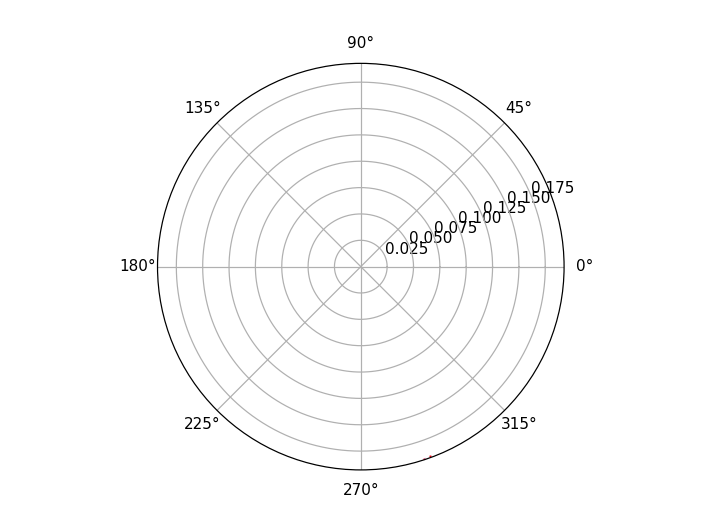

<IPython.core.display.Javascript object>


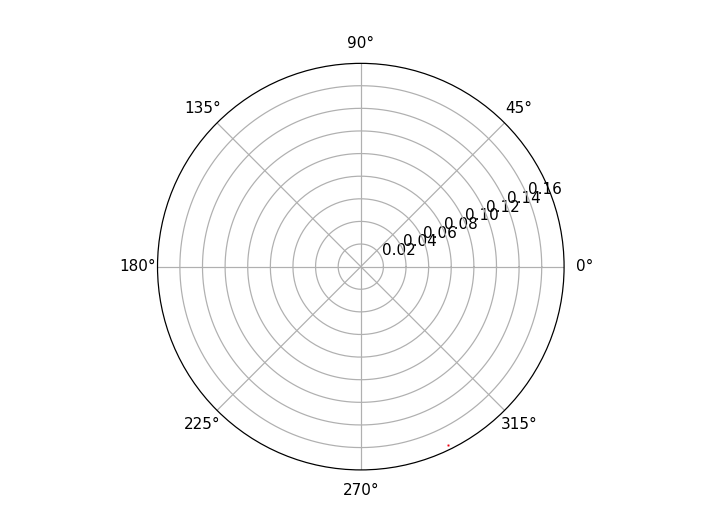

<IPython.core.display.Javascript object>


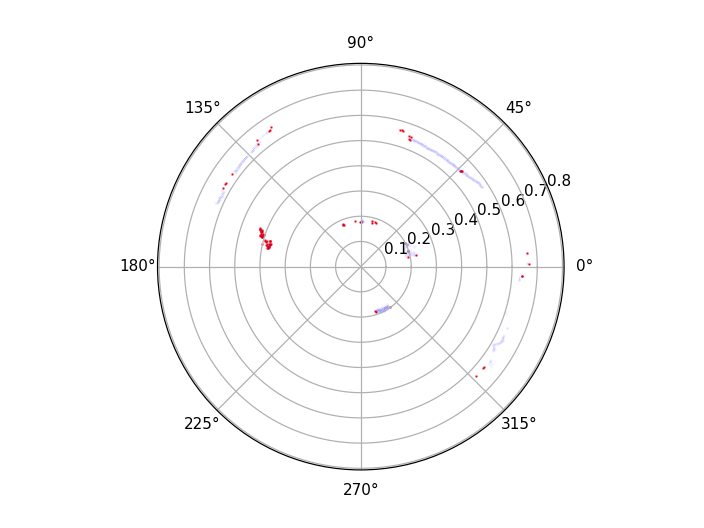

<IPython.core.display.Javascript object>


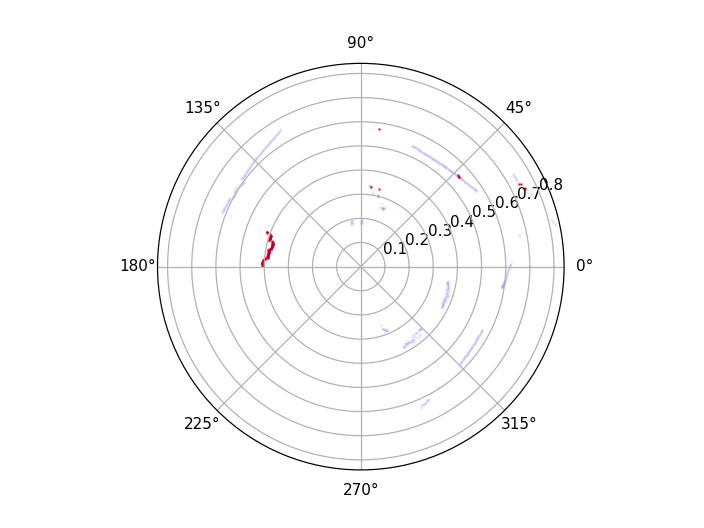

<IPython.core.display.Javascript object>


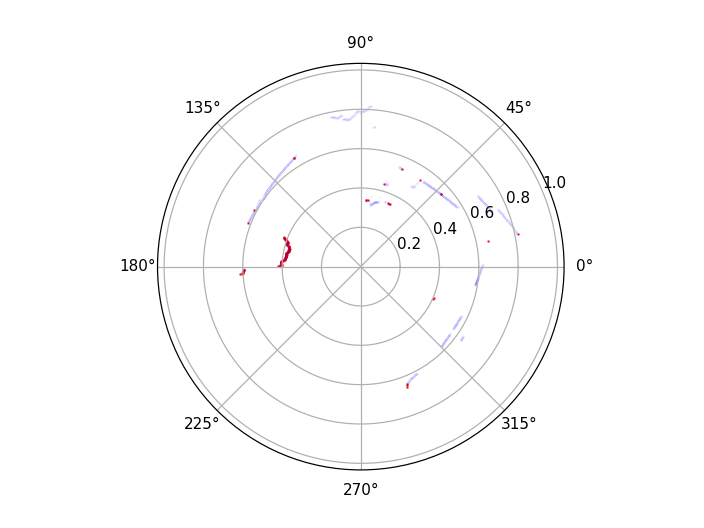

<IPython.core.display.Javascript object>


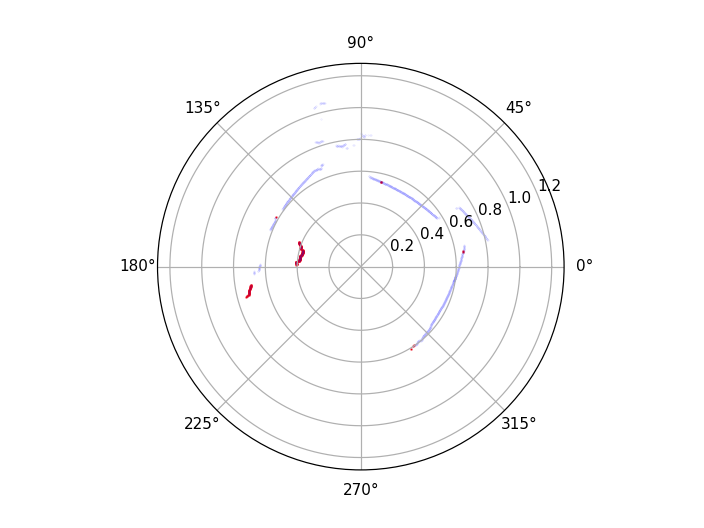

<IPython.core.display.Javascript object>


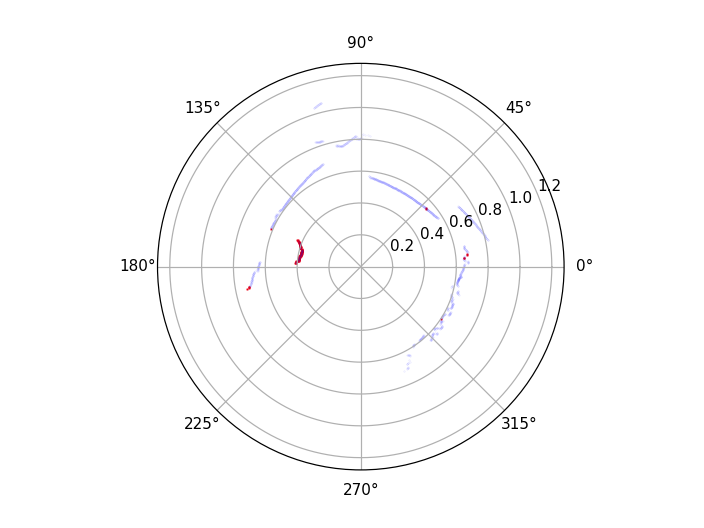

<IPython.core.display.Javascript object>


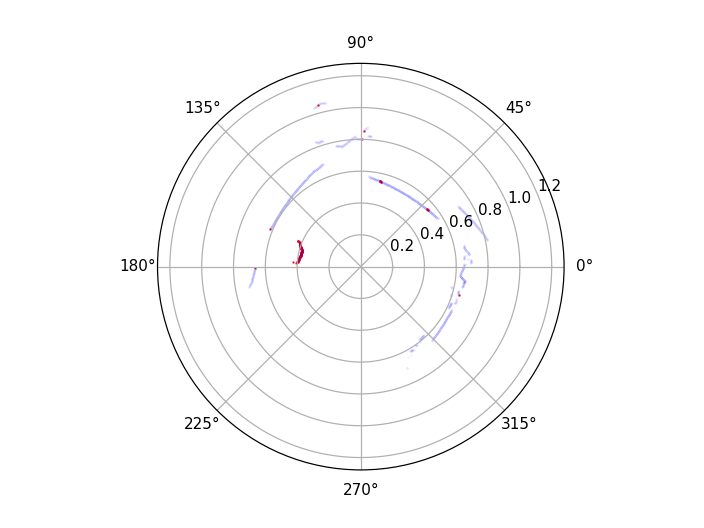

<IPython.core.display.Javascript object>


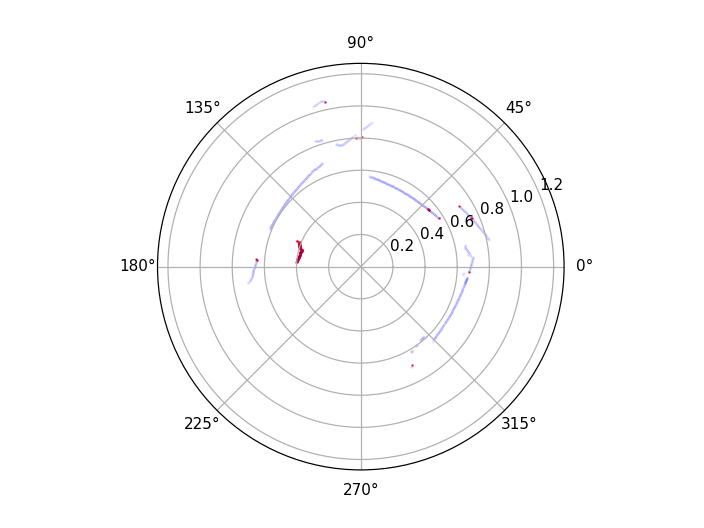

<IPython.core.display.Javascript object>


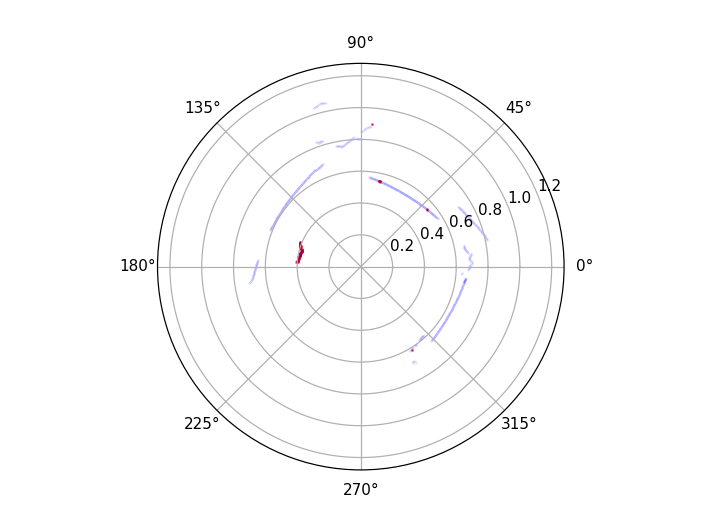

<IPython.core.display.Javascript object>


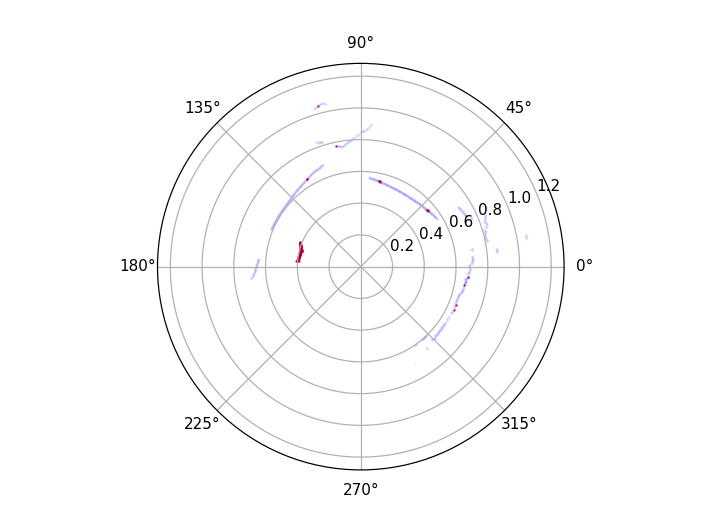

<IPython.core.display.Javascript object>


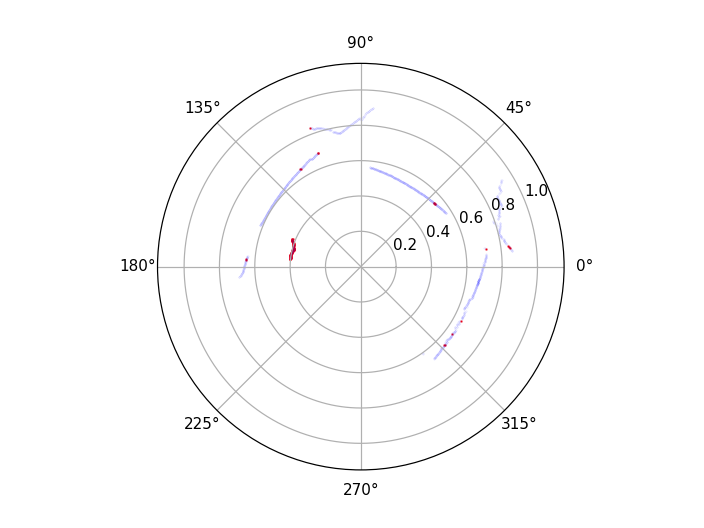

<IPython.core.display.Javascript object>


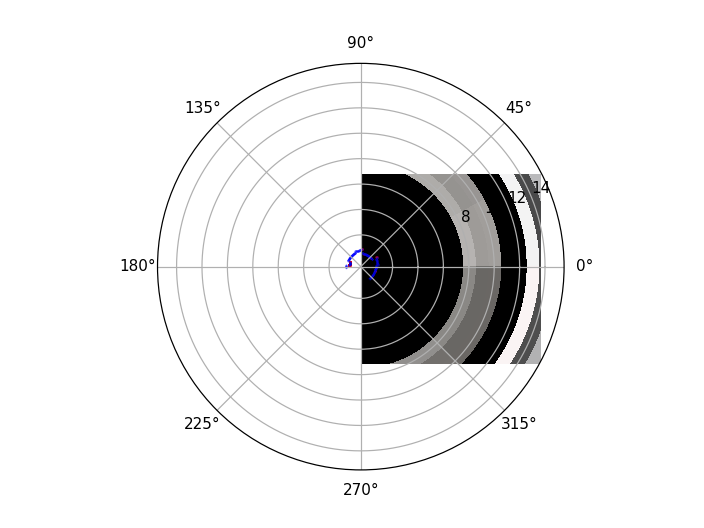

In [111]:
def read_decode_file(filename):
    loaded = np.load(filename)
    return loaded["gt"][()]

decoded_file = read_decode_file("data/0_120.npz")

for ring_id in decoded_file.keys():
    ring = decoded_file[ring_id]
    smoky_points = np.where(np.array(ring["label_gt"]) == 1)[0]
    # print smoky_points
    w_gt = np.array(ring["w_gt"])
    r_gt = np.array(ring["r_gt"])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    c = ax.scatter(w_gt[smoky_points], r_gt[smoky_points], cmap='hsv', alpha=1.0, s=0.2, marker='x', c='r')
    c = ax.scatter(w_gt, r_gt, cmap='hsv', alpha=0.1, s=0.1, marker='o', c='b')

In [112]:
decoded_file = read_decode_file("data/0_120.npz")

In [144]:
s = 0
for ring_id in decoded_file.keys():
    ring = decoded_file[ring_id]
    s += len(ring["x_gt"])
    print ring_id, len(ring["x_gt"])

print "total points:", s

data_in = np.zeros((4, 16, 1000))
data_out = np.zeros((1, 16, 1000))

dont_read = [3, 4, 5, 6]

for ring_id in decoded_file.keys():
    if ring_id in dont_read:
        continue
    
    
        
    ring = decoded_file[ring_id]
    print ring_id, len(ring["x_gt"])
    
    copy_till = min(1000, len(ring["y_gt"]))  
    data_in[0, ring_id, :copy_till] = ring["x_gt"][:copy_till]
    data_in[1, ring_id, :copy_till] = ring["y_gt"][:copy_till]
    data_in[2, ring_id, :copy_till] = ring["z_gt"][:copy_till]
    data_in[3, ring_id, :copy_till] = ring["i_gt"][:copy_till]
    
    data_out[0, ring_id, :copy_till] = ring["label_gt"][:copy_till]
    



3 4
4 2
5 576
6 945
7 892
8 1172
9 1194
10 1202
11 1209
12 1215
13 1153
14 1175
15 1192
total points: 11931
7 892
8 1172
9 1194
10 1202
11 1209
12 1215
13 1153
14 1175
15 1192


TypeError: Invalid dimensions for image data

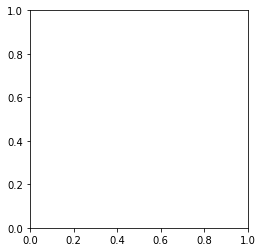

In [147]:
%matplotlib inline
plt.imshow(np.reshape(data_in[0], (16, 1000, -1)))
plt.show()

## Test on single frame

In [4]:
points = frames[0]
x = points[:,0]
y = points[:,1]
z = points[:,2]
w = np.arctan2(y, x)
r = np.sqrt(x*x+y*y)
j = np.arange(x.size)

<IPython.core.display.Javascript object>


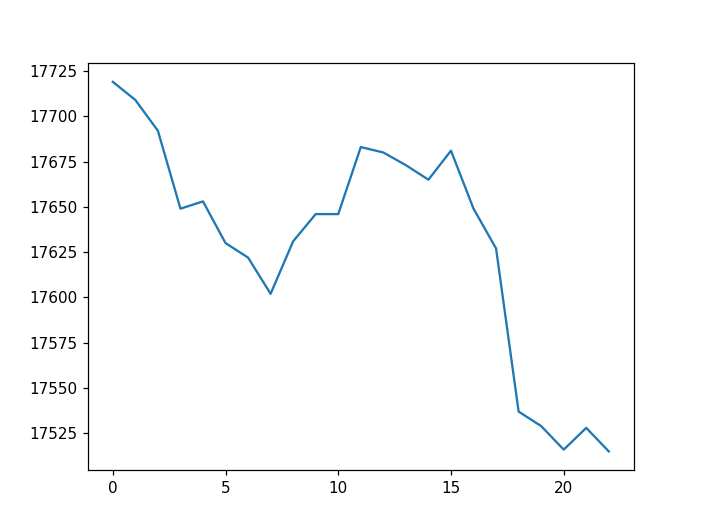

In [5]:
plt.figure()
plt.plot([len(frame) for frame in frames])

<IPython.core.display.Javascript object>


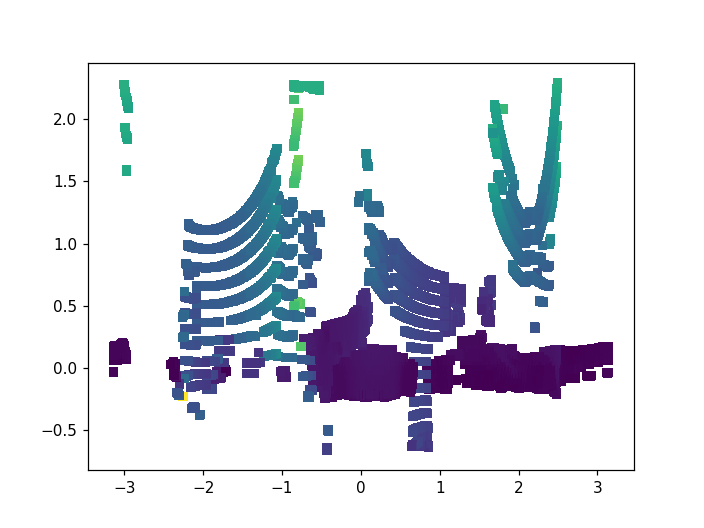

In [6]:
plt.figure()
plt.scatter(w, z, c=r, marker='s', edgecolor="none")

<IPython.core.display.Javascript object>


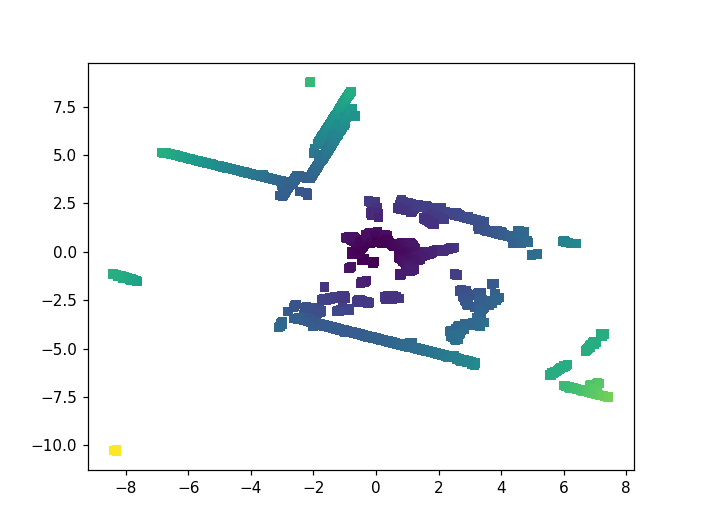

In [8]:
plt.figure()
plt.scatter(x,y, c=r, marker='s', edgecolor="none")

<IPython.core.display.Javascript object>


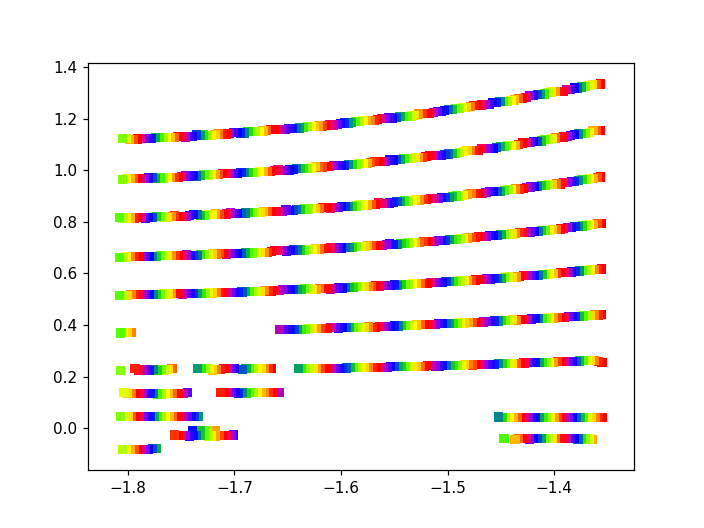

In [9]:
plt.figure()
plt.scatter(w[:1000],z[:1000], c=j[:1000], marker='s', edgecolor="none", cmap='prism')

In [ ]:
val = gridify(w,z,r, resolution=(200,100), value_approximation='min')[1]

In [ ]:
plt.figure()
plt.imshow(val)

## Animation

<IPython.core.display.Javascript object>


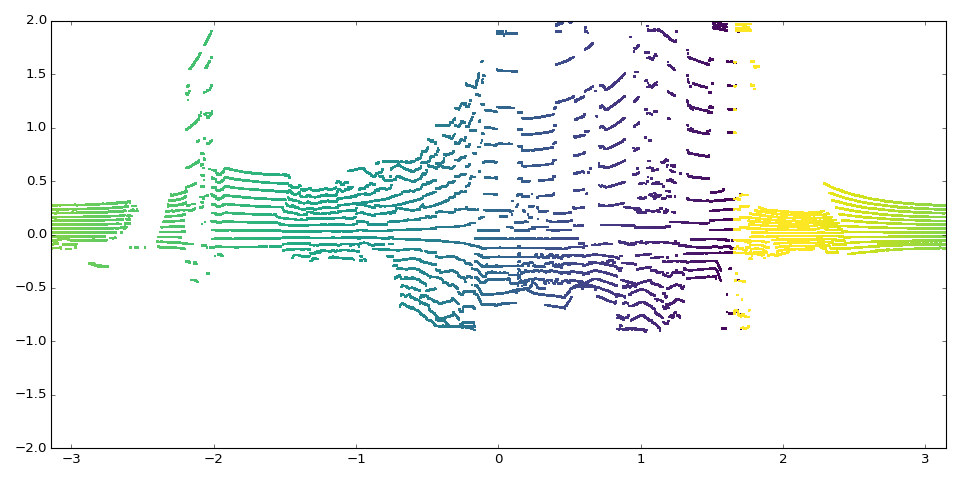

In [12]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
FPS = 30
fig = plt.figure("Generating Animation", figsize=(12,6))
norm = plt.Normalize()
ax = plt.axes()
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-2,2)
plt.tight_layout()
scat = ax.scatter([], [], c=[], marker='s', edgecolor="none", s=5)
def update(frame_number):
    points = frames[frame_number % len(frames)]
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    w = np.arctan2(y, x)
    r = np.sqrt(x*x+y*y)
    j = np.arange(x.size)
    scat.set_offsets(np.array([w,z]).T)
    scat.set_facecolor(plt.cm.viridis(norm(j)))
try:
  anim = FuncAnimation(fig, update, frames=len(frames), interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

In [ ]:
rc('animation', html='html5')
anim

In [ ]:
anim.save('/tmp/LIDAR.mp4', fps=FPS, extra_args=['-vcodec', 'libx264'])

<IPython.core.display.Javascript object>


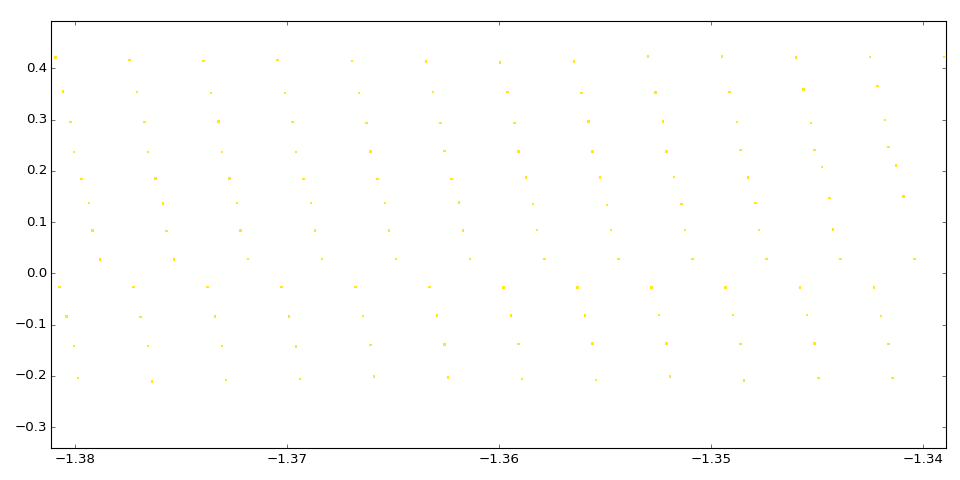

In [9]:
# Animating point order
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
FPS = 60
MULT = 20
fig3 = plt.figure("Generating Animation 2", figsize=(12,6))
norm = plt.Normalize()
ax3 = plt.axes()
ax3.set_xlim(-np.pi,np.pi)
ax3.set_ylim(-2,2)
plt.tight_layout()
points = frames[0]
x = points[:,0]
y = points[:,1]
z = points[:,2]
w = np.arctan2(y, x)
r = np.sqrt(x*x+y*y)
j = np.arange(x.size)
scat3 = ax3.scatter([], [], c=[], marker='s', edgecolor="none", s=5, vmin=min(r), vmax=max(r))
def update3(frame_number):
    i = frame_number*MULT
    scat3.set_offsets(np.array([w[:i],z[:i]]).T)
    scat3.set_facecolor(plt.cm.viridis(r[:i]))
try:
  anim3 = FuncAnimation(fig3, update3, frames=len(j)/MULT, interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

## Animation Gridified

In [ ]:
grids = []
for points in frames:
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    w = np.arctan2(y, x)
    r = np.sqrt(x*x+y*y)
    grids.append(gridify(w,z,r, resolution=(200,100), value_approximation='min')[1])

In [ ]:
from matplotlib import rc
from matplotlib.animation import FuncAnimation
#
FPS = 30
fig2 = plt.figure("PColorMesh Animation", figsize=(12,6))
ax2 = plt.axes()
plt.tight_layout()
im = ax2.imshow(grids[0])
def update2(frame_number):
    im.set_data(grids[frame_number % len(frames)])
    im.set_cmap(plt.get_cmap("viridis"))
try:
  anim2 = FuncAnimation(fig2, update2, frames=len(frames), interval=1000/FPS)
except KeyboardInterrupt:
  print("Ended.")

In [ ]:
anim2.save('/tmp/LIDAR_grid.mp4', fps=FPS, extra_args=['-vcodec', 'libx264'])